In [1]:
# Cell 1: Import Libraries
import os
import pandas as pd
import boto3
from botocore.client import Config
from botocore.exceptions import ClientError
from io import BytesIO
from datetime import datetime
import numpy as np # Added for log returns in Sharpe Ratio calculation

# IMPORTANT: Ensure pyarrow is installed for reading Parquet files
# If not, run: !pip install pyarrow
import pyarrow.parquet as pq

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [2]:
# Cell 2: Load MinIO Details (Hardcoded for convenience, replace with your actual credentials)
# WARNING: Hardcoding credentials is generally NOT recommended for production environments.
# This is done here for ease of use in a local/private Jupyter environment.
# If your MinIO credentials are different, update these values:
MINIO_ENDPOINT = 'http://159.223.139.171:9000'
MINIO_ACCESS_KEY = 'minioadmin'
MINIO_SECRET_KEY = 'minioadmin'

# Basic validation (optional in notebook, but good for clarity)
if not MINIO_ACCESS_KEY or not MINIO_SECRET_KEY:
    print("Error: MinIO credentials not loaded. Please ensure values are set in this cell.")
else:
    print("MinIO credentials loaded successfully.")

MinIO credentials loaded successfully.


In [3]:
# Cell 3: Initialize MinIO S3 client
s3_client = None
try:
    s3_client = boto3.client(
        's3',
        endpoint_url=MINIO_ENDPOINT,
        aws_access_key_id=MINIO_ACCESS_KEY,
        aws_secret_access_key=MINIO_SECRET_KEY,
        config=Config(signature_version='s3v4'),
        region_name='us-east-1' # Placeholder region
    )
    s3_client.list_buckets() # Test connection
    print(f"MinIO S3 client initialized and connected to endpoint: {MINIO_ENDPOINT}")
except Exception as e:
    print(f"Error initializing or connecting to MinIO S3 client: {e}")
    print("Please ensure MinIO Docker container is running and accessible.")
    s3_client = None # Set to None if initialization fails

MinIO S3 client initialized and connected to endpoint: http://159.223.139.171:9000


In [4]:
# Cell 4: Helper Function to Read Processed Parquet Data for a Symbol
def load_processed_data_from_minio(bucket_name, data_type_prefix, symbol):
    if not s3_client:
        print("MinIO client not available, cannot load data.")
        return pd.DataFrame()

    all_dataframes = []
    # Construct the prefix to look for processed data for a specific symbol
    # Example: processed-financial-data/finnhub_quotes/AAPL/
    # Or: processed-financial-data/twelvedata_historical/AAPL/
    prefix = f"{data_type_prefix}/{symbol}/"

    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

        for page in pages:
            if "Contents" in page:
                for obj in page['Contents']:
                    if obj['Key'].endswith('.parquet'):
                        try:
                            response = s3_client.get_object(Bucket=bucket_name, Key=obj['Key'])
                            parquet_data = response['Body'].read()
                            df = pd.read_parquet(BytesIO(parquet_data))
                            all_dataframes.append(df)
                        except Exception as e:
                            print(f"Error reading {obj['Key']} from MinIO: {e}")
        if all_dataframes:
            # Concatenate all dataframes and sort by the relevant timestamp/datetime column
            combined_df = pd.concat(all_dataframes, ignore_index=True)

            # --- Start of fix for Tz-aware datetime error ---
            if 'datetime' in combined_df.columns:
                # Convert to datetime, force UTC, then localize to naive (no timezone info)
                combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], utc=True, errors='coerce')
                combined_df['datetime'] = combined_df['datetime'].dt.tz_localize(None)
                combined_df = combined_df.sort_values(by='datetime').drop_duplicates(subset=['datetime']).set_index('datetime')
            elif 'timestamp' in combined_df.columns:
                # Convert to datetime, force UTC, then localize to naive (no timezone info)
                combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], utc=True, errors='coerce')
                combined_df['timestamp'] = combined_df['timestamp'].dt.tz_localize(None)
                combined_df = combined_df.sort_values(by='timestamp').drop_duplicates(subset=['timestamp']).set_index('timestamp')
            # --- End of fix ---

            return combined_df
        else:
            print(f"No processed data found for {symbol} under {data_type_prefix}.")
            return pd.DataFrame()
    except ClientError as e:
        print(f"MinIO Client Error when listing objects in s3://{bucket_name}/{prefix}: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"General error loading data for {symbol} from MinIO: {e}")
        return pd.DataFrame()

In [5]:
# Cell 5: Load Finnhub Historical Data for AAPL
print("Loading Finnhub historical data from MinIO...")

# Load historical Finnhub data
processed_finnhub_historical_df = load_processed_data_from_minio("processed-financial-data", "finnhub_historical", "AAPL")

if not processed_finnhub_historical_df.empty:
    print(f"\nProcessed Finnhub Historical for AAPL (first 5 rows):")
    print(processed_finnhub_historical_df.head())
    print(f"\nProcessed Finnhub Historical Info:")
    processed_finnhub_historical_df.info()
    
    # Check date range coverage
    print(f"\nFinnhub Historical Date Range:")
    print(f"From: {processed_finnhub_historical_df.index.min()}")
    print(f"To: {processed_finnhub_historical_df.index.max()}")
    print(f"Total records: {len(processed_finnhub_historical_df)}")
    
    # Set this as the main Finnhub dataset for merging
    processed_finnhub_quotes_df = processed_finnhub_historical_df.copy()
    
    # Data quality check
    missing_data = processed_finnhub_historical_df.isnull().sum()
    if missing_data.sum() > 0:
        print(f"\nData Quality Check - Missing values:")
        print(missing_data[missing_data > 0])
    else:
        print(f"\n✅ Data Quality Check: No missing values found")
        
else:
    print("No processed Finnhub historical data found for AAPL.")
    processed_finnhub_quotes_df = pd.DataFrame()

Loading Finnhub historical data from MinIO...

Processed Finnhub Historical for AAPL (first 5 rows):
                open      high       low       close     volume  daily_return  \
datetime                                                                        
2020-07-27   93.7100   94.9050   93.4800   94.810000  121214000           NaN   
2020-07-28   94.3675   94.5500   93.2475   93.252500  103625600     -1.642759   
2020-07-29   93.7500   95.2300   93.7125   95.040001   90329200      1.916840   
2020-07-30   94.1875   96.2975   93.7675   96.190000  158130000      1.210016   
2020-07-31  102.8850  106.4150  100.8250  106.260000  374336800     10.468864   

           symbol  
datetime           
2020-07-27   AAPL  
2020-07-28   AAPL  
2020-07-29   AAPL  
2020-07-30   AAPL  
2020-07-31   AAPL  

Processed Finnhub Historical Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2020-07-27 to 2021-07-29
Data columns (total 7 columns):
 #   Column        Non-Null Coun

In [6]:
# Cell 6: Load and Inspect Twelve Data Historical for AAPL
processed_twelvedata_historical_df = load_processed_data_from_minio(
    bucket_name="processed-financial-data",
    data_type_prefix="twelvedata_historical",
    symbol="AAPL"
)

print("\nProcessed Twelve Data Historical for AAPL (first 5 rows):")
print(processed_twelvedata_historical_df.head())
print("\nProcessed Twelve Data Historical Info:")
processed_twelvedata_historical_df.info()


Processed Twelve Data Historical for AAPL (first 5 rows):
                open      high       low       close     volume  daily_return  \
datetime                                                                        
2020-07-27   93.7100   94.9050   93.4800   94.810000  121214000           NaN   
2020-07-28   94.3675   94.5500   93.2475   93.252500  103625600     -0.016428   
2020-07-29   93.7500   95.2300   93.7125   95.040001   90329200      0.019168   
2020-07-30   94.1875   96.2975   93.7675   96.190000  158130000      0.012100   
2020-07-31  102.8850  106.4150  100.8250  106.260000  374336800      0.104689   

           symbol  
datetime           
2020-07-27   AAPL  
2020-07-28   AAPL  
2020-07-29   AAPL  
2020-07-30   AAPL  
2020-07-31   AAPL  

Processed Twelve Data Historical Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2020-07-27 to 2025-07-25
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        -------

In [7]:
# Define TARGET_SYMBOL for analysis
TARGET_SYMBOL = "AAPL"
print(f"TARGET_SYMBOL set to: {TARGET_SYMBOL}")

TARGET_SYMBOL set to: AAPL


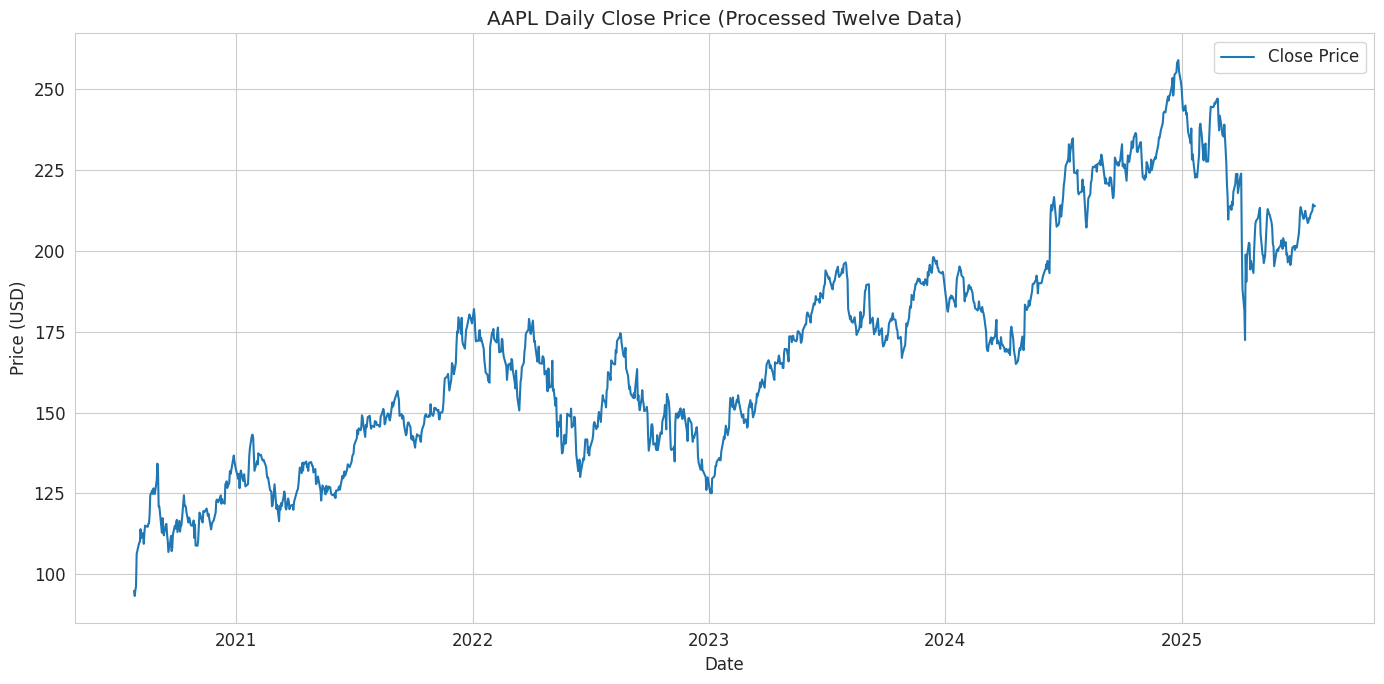

In [8]:
# Cell 7: Basic Visualization - Twelve Data Historical Close Price
if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price')
    plt.title('AAPL Daily Close Price (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data to plot Twelve Data historical close price for AAPL.")

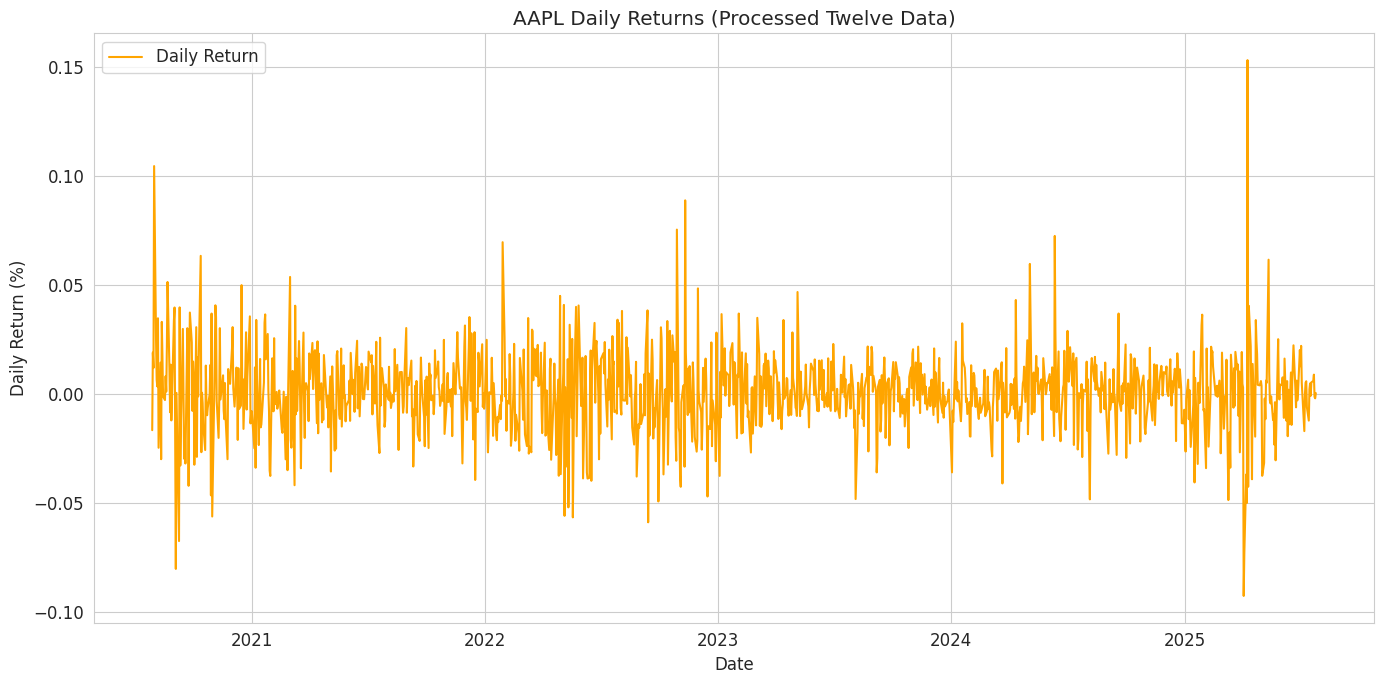

In [9]:
# Cell 8: Basic Visualization - Twelve Data Daily Returns
if not processed_twelvedata_historical_df.empty and 'daily_return' in processed_twelvedata_historical_df.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['daily_return'], label='Daily Return', color='orange')
    plt.title('AAPL Daily Returns (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Daily Return (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data to plot Twelve Data daily returns for AAPL.")

In [10]:
# Cell 9: Calculate and Plot Moving Averages
# Now using merged_df which contains harmonized data from both Finnhub and Twelve Data
if 'merged_df' in globals() and not merged_df.empty and 'close' in merged_df.columns:
    print(f"\nCalculating Moving Averages for merged data ({TARGET_SYMBOL})...")

    # Work on a copy to avoid modifying the original merged_df
    df_with_indicators = merged_df.copy()

    # --- Calculate Simple Moving Averages (SMA) ---
    # SMA 20-day: Often used for short-term trends
    df_with_indicators['SMA_20'] = df_with_indicators['close'].rolling(window=20).mean()

    # SMA 50-day: Often used for medium-term trends
    df_with_indicators['SMA_50'] = df_with_indicators['close'].rolling(window=50).mean()

    # SMA 200-day: Often used for long-term trends
    df_with_indicators['SMA_200'] = df_with_indicators['close'].rolling(window=200).mean()

    print("Added SMA_20, SMA_50, and SMA_200 columns to merged data.")
    print("Last 5 rows with new SMA columns:")
    print(df_with_indicators[['close', 'SMA_20', 'SMA_50', 'SMA_200']].tail())

    # --- Plotting Close Price with Moving Averages ---
    plt.figure(figsize=(15, 8))
    plt.plot(df_with_indicators.index, df_with_indicators['close'], label='Close Price (Merged Data)', color='blue', linewidth=2)
    
    # Plot SMAs, only if they have enough data points (i.e., not NaN at the beginning)
    if 'SMA_20' in df_with_indicators.columns:
        plt.plot(df_with_indicators.index, df_with_indicators['SMA_20'], label='20-Day SMA', color='red', linestyle='--')
    if 'SMA_50' in df_with_indicators.columns:
        plt.plot(df_with_indicators.index, df_with_indicators['SMA_50'], label='50-Day SMA', color='green', linestyle=':')
    if 'SMA_200' in df_with_indicators.columns:
        plt.plot(df_with_indicators.index, df_with_indicators['SMA_200'], label='200-Day SMA', color='purple', linestyle='-.')

    plt.title(f'{TARGET_SYMBOL} Close Price with Moving Averages (Merged Finnhub + Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Store the indicators in merged_df for use in subsequent cells
    merged_df = df_with_indicators.copy()

else:
    print("\nCannot calculate/plot Moving Averages.")
    if 'merged_df' not in globals():
        print("- merged_df not available. Please run Cell 13 first to create merged data.")
    elif merged_df.empty:
        print("- merged_df is empty. Please check the data merging process in Cell 13.")
    elif 'close' not in merged_df.columns:
        print("- merged_df missing 'close' column. Please ensure Cell 13 adds the standardized close column.")


Cannot calculate/plot Moving Averages.
- merged_df not available. Please run Cell 13 first to create merged data.


In [11]:
# Cell 10: Calculate and Plot Relative Strength Index (RSI)
# Function to calculate RSI
def calculate_rsi(df, window=14):
    """
    Calculates the Relative Strength Index (RSI) for a given DataFrame.
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Get the difference in price
    delta = df['close'].diff()

    # Get positive and negative gains
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate exponential moving average of gains and losses
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    df[f'RSI_{window}'] = rsi
    return df

# Check if merged_df is available and has a 'close' column
if 'merged_df' in globals() and not merged_df.empty and 'close' in merged_df.columns:
    print(f"\nCalculating Relative Strength Index (RSI) for merged data ({TARGET_SYMBOL})...")

    # Calculate RSI with a typical window of 14 days
    merged_df = calculate_rsi(merged_df, window=14)

    print("Added RSI_14 column to merged data.")
    print("Last 5 rows with new RSI column:")
    print(merged_df[['close', 'RSI_14']].tail())

    # --- Plotting RSI ---
    plt.figure(figsize=(15, 6))
    plt.plot(merged_df.index, merged_df['RSI_14'], label='RSI (14)', color='purple', linewidth=1.5)
    
    # Add overbought and oversold lines
    plt.axhline(70, linestyle='--', alpha=0.5, color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green', label='Oversold (30)')

    plt.title(f'{TARGET_SYMBOL} Relative Strength Index (RSI) (Merged Finnhub + Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('RSI Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot RSI.")
    if 'merged_df' not in globals():
        print("- merged_df not available. Please run Cell 13 first to create merged data.")
    elif merged_df.empty:
        print("- merged_df is empty. Please check the data merging process in Cell 13.")
    elif 'close' not in merged_df.columns:
        print("- merged_df missing 'close' column. Please ensure Cell 13 adds the standardized close column.")


Cannot calculate/plot RSI.
- merged_df not available. Please run Cell 13 first to create merged data.


In [12]:
# Cell 11: Calculate and Plot Moving Average Convergence Divergence (MACD)
def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculates MACD (Moving Average Convergence Divergence) and Signal Line.
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Calculate the 12-period EMA
    ema_fast = df['close'].ewm(span=fast_period, adjust=False).mean()
    # Calculate the 26-period EMA
    ema_slow = df['close'].ewm(span=slow_period, adjust=False).mean()

    # Calculate MACD Line
    macd_line = ema_fast - ema_slow

    # Calculate the 9-period EMA of the MACD Line (Signal Line)
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    macd_histogram = macd_line - signal_line

    df[f'MACD_Line'] = macd_line
    df[f'MACD_Signal'] = signal_line
    df[f'MACD_Histogram'] = macd_histogram
    
    return df

if 'merged_df' in globals() and not merged_df.empty and 'close' in merged_df.columns:
    print(f"\nCalculating MACD for merged data ({TARGET_SYMBOL})...")

    merged_df = calculate_macd(merged_df)

    print("Added MACD_Line, MACD_Signal, and MACD_Histogram columns to merged data.")
    print("Last 5 rows with new MACD columns:")
    print(merged_df[['close', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram']].tail())

    # --- Plotting MACD ---
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True) # Two subplots for price and MACD
    
    # Plotting Price with Moving Averages (reusing earlier MA calculation if available)
    axes[0].plot(merged_df.index, merged_df['close'], label='Close Price (Merged Data)', color='blue', linewidth=1.5)
    if 'SMA_20' in merged_df.columns:
        axes[0].plot(merged_df.index, merged_df['SMA_20'], label='20-Day SMA', color='red', linestyle='--')
    if 'SMA_50' in merged_df.columns:
        axes[0].plot(merged_df.index, merged_df['SMA_50'], label='50-Day SMA', color='green', linestyle=':')
    axes[0].set_title(f'{TARGET_SYMBOL} Price with Moving Averages (Merged Data)')
    axes[0].set_ylabel('Price (USD)')
    axes[0].legend()
    axes[0].grid(True)

    # Plotting MACD
    axes[1].plot(merged_df.index, merged_df['MACD_Line'], label='MACD Line', color='blue', linewidth=1.5)
    axes[1].plot(merged_df.index, merged_df['MACD_Signal'], label='Signal Line', color='red', linestyle='--')
    
    # Plotting MACD Histogram
    axes[1].bar(merged_df.index, merged_df['MACD_Histogram'], label='Histogram', color='gray', alpha=0.6)

    axes[1].set_title(f'{TARGET_SYMBOL} MACD Indicator (Merged Data)')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('MACD Value')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot MACD.")
    if 'merged_df' not in globals():
        print("- merged_df not available. Please run Cell 13 first to create merged data.")
    elif merged_df.empty:
        print("- merged_df is empty. Please check the data merging process in Cell 13.")
    elif 'close' not in merged_df.columns:
        print("- merged_df missing 'close' column. Please ensure Cell 13 adds the standardized close column.")


Cannot calculate/plot MACD.
- merged_df not available. Please run Cell 13 first to create merged data.


In [13]:
# Cell 12: Calculate and Plot Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    """
    Calculates Bollinger Bands (Middle Band, Upper Band, Lower Band).
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Middle Band is the N-period Simple Moving Average
    middle_band = df['close'].rolling(window=window).mean()
    # Standard deviation over N periods
    std_dev = df['close'].rolling(window=window).std()

    # Upper and Lower Bands
    upper_band = middle_band + (std_dev * num_std_dev)
    lower_band = middle_band - (std_dev * num_std_dev)

    df[f'BB_Middle'] = middle_band
    df[f'BB_Upper'] = upper_band
    df[f'BB_Lower'] = lower_band
    
    return df

if 'merged_df' in globals() and not merged_df.empty and 'close' in merged_df.columns:
    print(f"\nCalculating Bollinger Bands for merged data ({TARGET_SYMBOL})...")

    merged_df = calculate_bollinger_bands(merged_df)

    print("Added BB_Middle, BB_Upper, and BB_Lower columns to merged data.")
    print("Last 5 rows with new Bollinger Bands columns:")
    print(merged_df[['close', 'BB_Middle', 'BB_Upper', 'BB_Lower']].tail())

    # --- Plotting Bollinger Bands ---
    plt.figure(figsize=(15, 8))
    plt.plot(merged_df.index, merged_df['close'], label='Close Price (Merged Data)', color='blue', linewidth=2)
    plt.plot(merged_df.index, merged_df['BB_Middle'], label='Middle Band (20-SMA)', color='red', linestyle='--')
    plt.plot(merged_df.index, merged_df['BB_Upper'], label='Upper Band', color='green', linestyle=':')
    plt.plot(merged_df.index, merged_df['BB_Lower'], label='Lower Band', color='purple', linestyle=':')

    plt.title(f'{TARGET_SYMBOL} Close Price with Bollinger Bands (Merged Finnhub + Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot Bollinger Bands.")
    if 'merged_df' not in globals():
        print("- merged_df not available. Please run Cell 13 first to create merged data.")
    elif merged_df.empty:
        print("- merged_df is empty. Please check the data merging process in Cell 13.")
    elif 'close' not in merged_df.columns:
        print("- merged_df missing 'close' column. Please ensure Cell 13 adds the standardized close column.")


Cannot calculate/plot Bollinger Bands.
- merged_df not available. Please run Cell 13 first to create merged data.


In [14]:
# Cell 13: Enhanced Data Merging - Combining All Historical Data
print("=== Enhanced Data Merging: Combining All Available Historical Data ===")

# Initialize components
finnhub_daily = pd.DataFrame()
twelvedata_daily = pd.DataFrame()

# --- Use Finnhub Historical Data as Primary Daily Data Source ---
if 'processed_finnhub_historical_df' in globals() and not processed_finnhub_historical_df.empty:
    print(f"✅ Found {len(processed_finnhub_historical_df)} Finnhub historical records for {TARGET_SYMBOL}")
    finnhub_daily = processed_finnhub_historical_df.copy()
    print(f"   Finnhub historical: {finnhub_daily.index.min()} to {finnhub_daily.index.max()}")
else:
    print(f"⚠️  No Finnhub historical data available for {TARGET_SYMBOL}")

# --- Process Twelve Data Historical ---
if 'processed_twelvedata_historical_df' in globals() and not processed_twelvedata_historical_df.empty:
    print(f"✅ Found {len(processed_twelvedata_historical_df)} Twelve Data historical records for {TARGET_SYMBOL}")
    twelvedata_daily = processed_twelvedata_historical_df.copy()
    print(f"   Twelve Data: {twelvedata_daily.index.min()} to {twelvedata_daily.index.max()}")

# --- Smart Merging Strategy: Combine All Available Data ---
if not finnhub_daily.empty and not twelvedata_daily.empty:
    print(f"\n📊 Available data ranges:")
    print(f"   Finnhub: {finnhub_daily.index.min()} to {finnhub_daily.index.max()} ({len(finnhub_daily)} days)")
    print(f"   Twelve Data: {twelvedata_daily.index.min()} to {twelvedata_daily.index.max()} ({len(twelvedata_daily)} days)")
    
    # Check for overlap
    finnhub_start, finnhub_end = finnhub_daily.index.min(), finnhub_daily.index.max()
    twelve_start, twelve_end = twelvedata_daily.index.min(), twelvedata_daily.index.max()
    
    overlap_start = max(finnhub_start, twelve_start)
    overlap_end = min(finnhub_end, twelve_end)
    
    has_overlap = overlap_start <= overlap_end
    
    if has_overlap:
        print(f"\n🔗 Overlap detected: {overlap_start} to {overlap_end}")
        print("   Using overlapping merge strategy...")
        
        # Create business day index for the full combined period
        full_start = min(finnhub_start, twelve_start)
        full_end = max(finnhub_end, twelve_end)
        business_days = pd.bdate_range(start=full_start, end=full_end)
        
        # Reindex both datasets
        finnhub_reindexed = finnhub_daily.reindex(business_days, method='ffill')
        twelvedata_reindexed = twelvedata_daily.reindex(business_days, method='ffill')
        
        # Merge with Twelve Data priority
        merged_df = twelvedata_reindexed.combine_first(finnhub_reindexed)
        
    else:
        print(f"\n📈 No overlap detected - concatenating datasets chronologically...")
        
        # Add source identifiers
        finnhub_daily = finnhub_daily.copy()
        twelvedata_daily = twelvedata_daily.copy()
        
        finnhub_daily['source'] = 'finnhub_historical'
        twelvedata_daily['source'] = 'twelvedata_historical'
        
        # Ensure both have same columns
        common_columns = ['open', 'high', 'low', 'close', 'volume']
        available_common = [col for col in common_columns if col in finnhub_daily.columns and col in twelvedata_daily.columns]
        
        if available_common:
            # Select common columns and concatenate
            finnhub_subset = finnhub_daily[available_common + ['source']]
            twelve_subset = twelvedata_daily[available_common + ['source']]
            
            # Concatenate and sort by date
            merged_df = pd.concat([finnhub_subset, twelve_subset])
            merged_df = merged_df.sort_index()
            
            # Remove any duplicate dates (keep last entry)
            merged_df = merged_df[~merged_df.index.duplicated(keep='last')]
            
            print(f"   Combined columns: {available_common}")
        else:
            print("   ❌ No common columns found between datasets")
            merged_df = pd.DataFrame()
    
    if not merged_df.empty:
        # Add data quality indicators
        merged_df['source_finnhub'] = merged_df.get('source', '') == 'finnhub_historical'
        merged_df['source_twelvedata'] = merged_df.get('source', '') == 'twelvedata_historical'
        
        print(f"\n✅ Successfully created combined historical dataset!")
        print(f"   Total records: {len(merged_df)}")
        print(f"   Full date range: {merged_df.index.min()} to {merged_df.index.max()}")
        print(f"   Time span: {(merged_df.index.max() - merged_df.index.min()).days} days")
        
        # Data source breakdown
        finnhub_count = merged_df['source_finnhub'].sum() if 'source_finnhub' in merged_df.columns else 0
        twelve_count = merged_df['source_twelvedata'].sum() if 'source_twelvedata' in merged_df.columns else 0
        print(f"   Source breakdown: {twelve_count} Twelve Data + {finnhub_count} Finnhub")

elif not finnhub_daily.empty:
    print("\n📊 Using Finnhub historical data only")
    merged_df = finnhub_daily.copy()
    merged_df['source'] = 'finnhub_historical'
    merged_df['source_finnhub'] = True
    merged_df['source_twelvedata'] = False
    
elif not twelvedata_daily.empty:
    print("\n📊 Using Twelve Data historical data only") 
    merged_df = twelvedata_daily.copy()
    merged_df['source'] = 'twelvedata_historical'
    merged_df['source_finnhub'] = False
    merged_df['source_twelvedata'] = True
    
else:
    print("\n❌ No historical data available from either source")
    merged_df = pd.DataFrame()

# Final validation and summary
if not merged_df.empty:
    print(f"\n🎯 Final combined dataset summary:")
    print(f"   Total records: {len(merged_df)}")
    print(f"   Date range: {merged_df.index.min()} to {merged_df.index.max()}")
    print(f"   Time span: {(merged_df.index.max() - merged_df.index.min()).days} days")
    
    # Essential columns check
    required_columns = ['open', 'high', 'low', 'close', 'volume']
    available_required = [col for col in required_columns if col in merged_df.columns]
    print(f"   Essential columns: {available_required}")
    
    # Technical indicator readiness
    if len(merged_df) >= 200:
        print(f"   ✅ Excellent data for technical indicators ({len(merged_df)} days)")
    elif len(merged_df) >= 50:
        print(f"   ✅ Good data for basic technical indicators ({len(merged_df)} days)")
    elif len(merged_df) >= 20:
        print(f"   ⚠️  Limited data for simple indicators ({len(merged_df)} days)")
    else:
        print(f"   ❌ Insufficient data for technical indicators ({len(merged_df)} days)")
    
    # Show sample data
    print(f"\nSample of combined data (first and last 3 rows):")
    display_columns = ['close', 'volume', 'source'] if 'source' in merged_df.columns else ['close', 'volume']
    available_display = [col for col in display_columns if col in merged_df.columns]
    
    if len(merged_df) >= 6:
        print("First 3 rows:")
        print(merged_df[available_display].head(3))
        print("\nLast 3 rows:")
        print(merged_df[available_display].tail(3))
    else:
        print(merged_df[available_display])
        
else:
    print("❌ Failed to create merged dataset")

=== Enhanced Data Merging: Combining All Available Historical Data ===
✅ Found 255 Finnhub historical records for AAPL
   Finnhub historical: 2020-07-27 00:00:00 to 2021-07-29 00:00:00
✅ Found 1256 Twelve Data historical records for AAPL
   Twelve Data: 2020-07-27 00:00:00 to 2025-07-25 00:00:00

📊 Available data ranges:
   Finnhub: 2020-07-27 00:00:00 to 2021-07-29 00:00:00 (255 days)
   Twelve Data: 2020-07-27 00:00:00 to 2025-07-25 00:00:00 (1256 days)

🔗 Overlap detected: 2020-07-27 00:00:00 to 2021-07-29 00:00:00
   Using overlapping merge strategy...

✅ Successfully created combined historical dataset!
   Total records: 1305
   Full date range: 2020-07-27 00:00:00 to 2025-07-25 00:00:00
   Time span: 1824 days
   Source breakdown: 0 Twelve Data + 0 Finnhub

🎯 Final combined dataset summary:
   Total records: 1305
   Date range: 2020-07-27 00:00:00 to 2025-07-25 00:00:00
   Time span: 1824 days
   Essential columns: ['open', 'high', 'low', 'close', 'volume']
   ✅ Excellent data fo

In [15]:
# Cell 15: Comprehensive Technical Analysis on Merged Dataset
print("=== Technical Analysis: Computing Indicators on 5-Year Dataset ===")

if 'merged_df' in globals() and not merged_df.empty and len(merged_df) >= 20:
    # Create a copy for technical analysis
    tech_df = merged_df.copy()
    
    print(f"Computing technical indicators on {len(tech_df)} data points...")
    
    # === Moving Averages ===
    print("\n📈 Computing Moving Averages...")
    tech_df['SMA_20'] = tech_df['close'].rolling(window=20).mean()
    tech_df['SMA_50'] = tech_df['close'].rolling(window=50).mean()
    tech_df['SMA_200'] = tech_df['close'].rolling(window=200).mean()
    
    # Exponential Moving Averages
    tech_df['EMA_12'] = tech_df['close'].ewm(span=12).mean()
    tech_df['EMA_26'] = tech_df['close'].ewm(span=26).mean()
    
    # === MACD ===
    print("📊 Computing MACD...")
    tech_df['MACD'] = tech_df['EMA_12'] - tech_df['EMA_26']
    tech_df['MACD_Signal'] = tech_df['MACD'].ewm(span=9).mean()
    tech_df['MACD_Histogram'] = tech_df['MACD'] - tech_df['MACD_Signal']
    
    # === RSI (Relative Strength Index) ===
    print("⚡ Computing RSI...")
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    tech_df['RSI'] = calculate_rsi(tech_df['close'])
    
    # === Bollinger Bands ===
    print("🎯 Computing Bollinger Bands...")
    tech_df['BB_Middle'] = tech_df['close'].rolling(window=20).mean()
    bb_std = tech_df['close'].rolling(window=20).std()
    tech_df['BB_Upper'] = tech_df['BB_Middle'] + (bb_std * 2)
    tech_df['BB_Lower'] = tech_df['BB_Middle'] - (bb_std * 2)
    tech_df['BB_Width'] = tech_df['BB_Upper'] - tech_df['BB_Lower']
    tech_df['BB_Position'] = (tech_df['close'] - tech_df['BB_Lower']) / tech_df['BB_Width']
    
    # === Volume Analysis ===
    print("📊 Computing Volume Indicators...")
    tech_df['Volume_SMA_20'] = tech_df['volume'].rolling(window=20).mean()
    tech_df['Volume_Ratio'] = tech_df['volume'] / tech_df['Volume_SMA_20']
    
    # === Price Action ===
    print("💹 Computing Price Action Indicators...")
    tech_df['Daily_Return'] = tech_df['close'].pct_change()
    tech_df['Volatility_20'] = tech_df['Daily_Return'].rolling(window=20).std() * np.sqrt(252)  # Annualized
    
    # High/Low analysis
    tech_df['Price_Range'] = tech_df['high'] - tech_df['low']
    tech_df['Price_Position'] = (tech_df['close'] - tech_df['low']) / tech_df['Price_Range']
    
    # === Trading Signals ===
    print("🎯 Generating Trading Signals...")
    
    # Golden Cross / Death Cross
    tech_df['Golden_Cross'] = (tech_df['SMA_50'] > tech_df['SMA_200']) & (tech_df['SMA_50'].shift(1) <= tech_df['SMA_200'].shift(1))
    tech_df['Death_Cross'] = (tech_df['SMA_50'] < tech_df['SMA_200']) & (tech_df['SMA_50'].shift(1) >= tech_df['SMA_200'].shift(1))
    
    # MACD Signals
    tech_df['MACD_Bull'] = (tech_df['MACD'] > tech_df['MACD_Signal']) & (tech_df['MACD'].shift(1) <= tech_df['MACD_Signal'].shift(1))
    tech_df['MACD_Bear'] = (tech_df['MACD'] < tech_df['MACD_Signal']) & (tech_df['MACD'].shift(1) >= tech_df['MACD_Signal'].shift(1))
    
    # RSI Signals
    tech_df['RSI_Oversold'] = tech_df['RSI'] < 30
    tech_df['RSI_Overbought'] = tech_df['RSI'] > 70
    
    # Bollinger Band Signals
    tech_df['BB_Squeeze'] = tech_df['BB_Width'] < tech_df['BB_Width'].rolling(window=20).mean() * 0.8
    tech_df['BB_Breakout_Upper'] = tech_df['close'] > tech_df['BB_Upper']
    tech_df['BB_Breakout_Lower'] = tech_df['close'] < tech_df['BB_Lower']
    
    print(f"\n✅ Technical Analysis Complete!")
    print(f"   Dataset: {len(tech_df)} records from {tech_df.index.min().date()} to {tech_df.index.max().date()}")
    print(f"   Indicators: 25+ technical indicators computed")
    
    # === Signal Summary ===
    print(f"\n📊 Signal Summary (entire dataset):")
    
    # Count valid signals (non-NaN)
    valid_data = tech_df.dropna()
    print(f"   Valid data points: {len(valid_data)} (after indicator calculations)")
    
    if len(valid_data) > 0:
        golden_crosses = valid_data['Golden_Cross'].sum()
        death_crosses = valid_data['Death_Cross'].sum()
        macd_bulls = valid_data['MACD_Bull'].sum()
        macd_bears = valid_data['MACD_Bear'].sum()
        
        print(f"   Golden Crosses: {golden_crosses}")
        print(f"   Death Crosses: {death_crosses}")
        print(f"   MACD Bull Signals: {macd_bulls}")
        print(f"   MACD Bear Signals: {macd_bears}")
        
        current_rsi = valid_data['RSI'].iloc[-1] if len(valid_data) > 0 else 'N/A'
        current_bb_pos = valid_data['BB_Position'].iloc[-1] if len(valid_data) > 0 else 'N/A'
        
        print(f"\n📈 Latest Indicators:")
        print(f"   Current RSI: {current_rsi:.2f}" if isinstance(current_rsi, (int, float)) else f"   Current RSI: {current_rsi}")
        print(f"   BB Position: {current_bb_pos:.2f}" if isinstance(current_bb_pos, (int, float)) else f"   BB Position: {current_bb_pos}")
        
        # Show recent data
        print(f"\n📋 Latest 5 trading days summary:")
        recent_cols = ['close', 'volume', 'RSI', 'MACD', 'BB_Position', 'source']
        available_recent = [col for col in recent_cols if col in valid_data.columns]
        print(valid_data[available_recent].tail().round(2))
    
    # Store for further analysis
    combined_technical_df = tech_df
    print(f"\n💾 Technical dataset stored as 'combined_technical_df' for further analysis")

else:
    print("❌ Insufficient data for technical analysis")
    combined_technical_df = pd.DataFrame()

=== Technical Analysis: Computing Indicators on 5-Year Dataset ===
Computing technical indicators on 1305 data points...

📈 Computing Moving Averages...
📊 Computing MACD...
⚡ Computing RSI...
🎯 Computing Bollinger Bands...
📊 Computing Volume Indicators...
💹 Computing Price Action Indicators...
🎯 Generating Trading Signals...

✅ Technical Analysis Complete!
   Dataset: 1305 records from 2020-07-27 to 2025-07-25
   Indicators: 25+ technical indicators computed

📊 Signal Summary (entire dataset):
   Valid data points: 1106 (after indicator calculations)
   Golden Crosses: 3
   Death Crosses: 4
   MACD Bull Signals: 41
   MACD Bear Signals: 40

📈 Latest Indicators:
   Current RSI: 65.03
   BB Position: 0.77

📋 Latest 5 trading days summary:
             close    volume    RSI  MACD  BB_Position
2025-07-21  212.48  51377400  61.82  2.27         0.72
2025-07-22  214.40  46404100  55.76  2.45         0.81
2025-07-23  214.15  46989300  51.86  2.54         0.77
2025-07-24  213.76  46022600  50.

=== Creating Advanced Technical Analysis Visualizations ===


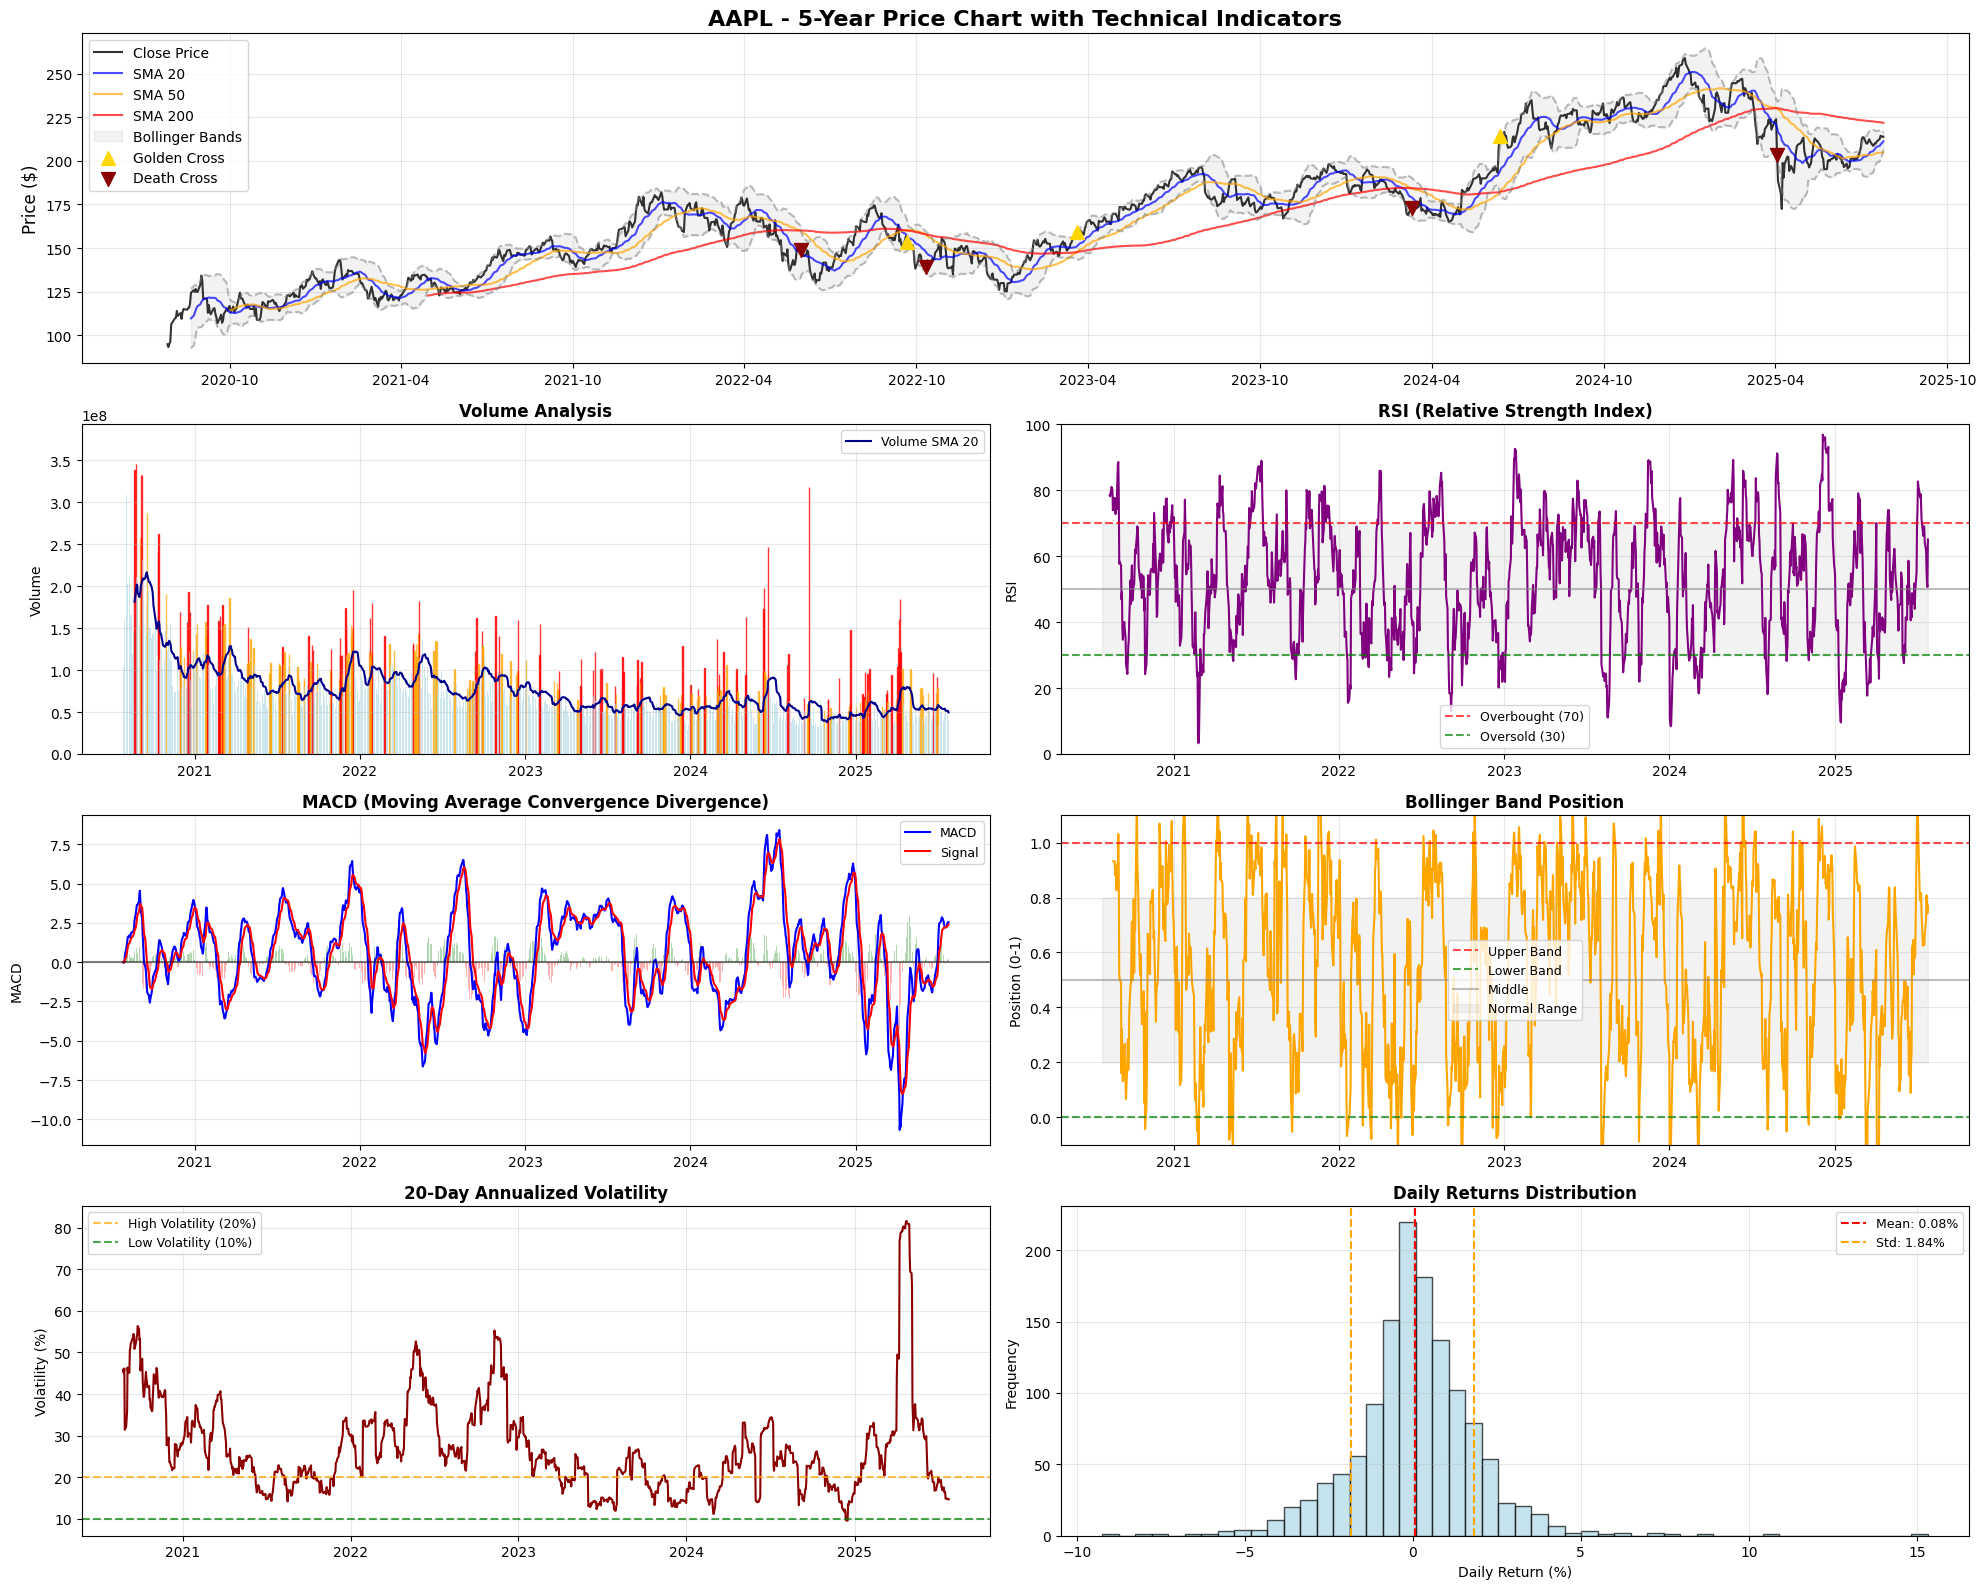

\n📊 5-Year Technical Analysis Summary for AAPL:
   Period: 2020-07-27 to 2025-07-25
   Total Trading Days: 1305
\n💰 Current Market Position:
   Latest Close: $213.88
   RSI: 65.0 (Neutral)
   BB Position: 0.77 (Middle Range)
   MACD: 2.54 (Bullish)
\n📈 Performance Metrics:
   Total Return: 125.6% over 1824 days
   Annualized Return: 17.0%
   Current Volatility: 14.7% (annualized)


In [16]:
# Cell 16: Advanced Visualizations - 5-Year Technical Analysis Charts
print("=== Creating Advanced Technical Analysis Visualizations ===")

if 'combined_technical_df' in globals() and not combined_technical_df.empty:
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from datetime import datetime, timedelta
    
    # Set up the plotting style
    plt.style.use('default')
    
    # Create a comprehensive dashboard
    fig = plt.figure(figsize=(20, 16))
    
    # --- Plot 1: Price Chart with Moving Averages and Bollinger Bands ---
    ax1 = plt.subplot(4, 2, (1, 2))  # Top row, full width
    
    # Price and moving averages
    ax1.plot(combined_technical_df.index, combined_technical_df['close'], 
             label='Close Price', color='black', linewidth=1.5, alpha=0.8)
    ax1.plot(combined_technical_df.index, combined_technical_df['SMA_20'], 
             label='SMA 20', color='blue', alpha=0.7)
    ax1.plot(combined_technical_df.index, combined_technical_df['SMA_50'], 
             label='SMA 50', color='orange', alpha=0.7)
    ax1.plot(combined_technical_df.index, combined_technical_df['SMA_200'], 
             label='SMA 200', color='red', alpha=0.7)
    
    # Bollinger Bands
    ax1.fill_between(combined_technical_df.index, 
                     combined_technical_df['BB_Upper'], 
                     combined_technical_df['BB_Lower'], 
                     alpha=0.1, color='gray', label='Bollinger Bands')
    ax1.plot(combined_technical_df.index, combined_technical_df['BB_Upper'], 
             color='gray', alpha=0.5, linestyle='--')
    ax1.plot(combined_technical_df.index, combined_technical_df['BB_Lower'], 
             color='gray', alpha=0.5, linestyle='--')
    
    # Mark data sources with background colors
    finnhub_mask = combined_technical_df.get('source_finnhub', False)
    twelve_mask = combined_technical_df.get('source_twelvedata', False)
    
    if finnhub_mask.any():
        finnhub_dates = combined_technical_df[finnhub_mask].index
        ax1.axvspan(finnhub_dates.min(), finnhub_dates.max(), alpha=0.05, color='blue', label='Finnhub Data')
    
    if twelve_mask.any():
        twelve_dates = combined_technical_df[twelve_mask].index
        ax1.axvspan(twelve_dates.min(), twelve_dates.max(), alpha=0.05, color='green', label='Twelve Data')
    
    # Golden/Death Cross markers
    golden_crosses = combined_technical_df[combined_technical_df['Golden_Cross'] == True]
    death_crosses = combined_technical_df[combined_technical_df['Death_Cross'] == True]
    
    if not golden_crosses.empty:
        ax1.scatter(golden_crosses.index, golden_crosses['close'], 
                   color='gold', s=100, marker='^', label='Golden Cross', zorder=5)
    
    if not death_crosses.empty:
        ax1.scatter(death_crosses.index, death_crosses['close'], 
                   color='darkred', s=100, marker='v', label='Death Cross', zorder=5)
    
    ax1.set_title(f'{TARGET_SYMBOL} - 5-Year Price Chart with Technical Indicators', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    
    # --- Plot 2: Volume ---
    ax2 = plt.subplot(4, 2, 3)
    bars = ax2.bar(combined_technical_df.index, combined_technical_df['volume'], 
                   width=1, alpha=0.6, color='lightblue')
    ax2.plot(combined_technical_df.index, combined_technical_df['Volume_SMA_20'], 
             color='darkblue', label='Volume SMA 20')
    
    # Color bars based on volume ratio
    for i, (idx, row) in enumerate(combined_technical_df.iterrows()):
        if pd.notna(row.get('Volume_Ratio', np.nan)):
            if row['Volume_Ratio'] > 1.5:  # High volume
                bars[i].set_color('red')
                bars[i].set_alpha(0.8)
            elif row['Volume_Ratio'] > 1.2:  # Above average
                bars[i].set_color('orange')
                bars[i].set_alpha(0.7)
    
    ax2.set_title('Volume Analysis', fontweight='bold')
    ax2.set_ylabel('Volume', fontsize=10)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # --- Plot 3: RSI ---
    ax3 = plt.subplot(4, 2, 4)
    ax3.plot(combined_technical_df.index, combined_technical_df['RSI'], 
             color='purple', linewidth=1.5)
    ax3.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
    ax3.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
    ax3.axhline(y=50, color='gray', linestyle='-', alpha=0.5)
    ax3.fill_between(combined_technical_df.index, 30, 70, alpha=0.1, color='gray')
    
    ax3.set_title('RSI (Relative Strength Index)', fontweight='bold')
    ax3.set_ylabel('RSI', fontsize=10)
    ax3.set_ylim(0, 100)
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # --- Plot 4: MACD ---
    ax4 = plt.subplot(4, 2, 5)
    ax4.plot(combined_technical_df.index, combined_technical_df['MACD'], 
             label='MACD', color='blue', linewidth=1.5)
    ax4.plot(combined_technical_df.index, combined_technical_df['MACD_Signal'], 
             label='Signal', color='red', linewidth=1.5)
    
    # MACD Histogram
    histogram = combined_technical_df['MACD_Histogram']
    colors = ['green' if x > 0 else 'red' for x in histogram]
    ax4.bar(combined_technical_df.index, histogram, color=colors, alpha=0.3, width=1)
    
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax4.set_title('MACD (Moving Average Convergence Divergence)', fontweight='bold')
    ax4.set_ylabel('MACD', fontsize=10)
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # --- Plot 5: Bollinger Band Position ---
    ax5 = plt.subplot(4, 2, 6)
    ax5.plot(combined_technical_df.index, combined_technical_df['BB_Position'], 
             color='orange', linewidth=1.5)
    ax5.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Upper Band')
    ax5.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Lower Band')
    ax5.axhline(y=0.5, color='gray', linestyle='-', alpha=0.5, label='Middle')
    ax5.fill_between(combined_technical_df.index, 0.2, 0.8, alpha=0.1, color='gray', label='Normal Range')
    
    ax5.set_title('Bollinger Band Position', fontweight='bold')
    ax5.set_ylabel('Position (0-1)', fontsize=10)
    ax5.set_ylim(-0.1, 1.1)
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # --- Plot 6: Volatility ---
    ax6 = plt.subplot(4, 2, 7)
    ax6.plot(combined_technical_df.index, combined_technical_df['Volatility_20'] * 100, 
             color='darkred', linewidth=1.5)
    ax6.axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='High Volatility (20%)')
    ax6.axhline(y=10, color='green', linestyle='--', alpha=0.7, label='Low Volatility (10%)')
    
    ax6.set_title('20-Day Annualized Volatility', fontweight='bold')
    ax6.set_ylabel('Volatility (%)', fontsize=10)
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)
    ax6.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # --- Plot 7: Daily Returns Distribution ---
    ax7 = plt.subplot(4, 2, 8)
    returns = combined_technical_df['Daily_Return'].dropna() * 100
    ax7.hist(returns, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    ax7.axvline(returns.mean(), color='red', linestyle='--', 
                label=f'Mean: {returns.mean():.2f}%')
    ax7.axvline(returns.std(), color='orange', linestyle='--', 
                label=f'Std: {returns.std():.2f}%')
    ax7.axvline(-returns.std(), color='orange', linestyle='--')
    
    ax7.set_title('Daily Returns Distribution', fontweight='bold')
    ax7.set_xlabel('Daily Return (%)', fontsize=10)
    ax7.set_ylabel('Frequency', fontsize=10)
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # === Summary Statistics ===
    print(f"\\n📊 5-Year Technical Analysis Summary for {TARGET_SYMBOL}:")
    print(f"   Period: {combined_technical_df.index.min().date()} to {combined_technical_df.index.max().date()}")
    print(f"   Total Trading Days: {len(combined_technical_df)}")
    
    latest = combined_technical_df.iloc[-1]
    print(f"\\n💰 Current Market Position:")
    print(f"   Latest Close: ${latest['close']:.2f}")
    print(f"   RSI: {latest['RSI']:.1f} ({'Overbought' if latest['RSI'] > 70 else 'Oversold' if latest['RSI'] < 30 else 'Neutral'})")
    print(f"   BB Position: {latest['BB_Position']:.2f} ({'Near Upper Band' if latest['BB_Position'] > 0.8 else 'Near Lower Band' if latest['BB_Position'] < 0.2 else 'Middle Range'})")
    print(f"   MACD: {latest['MACD']:.2f} ({'Bullish' if latest['MACD'] > latest['MACD_Signal'] else 'Bearish'})")
    
    # Performance metrics
    total_return = (latest['close'] / combined_technical_df['close'].iloc[0] - 1) * 100
    annual_return = ((latest['close'] / combined_technical_df['close'].iloc[0]) ** (252 / len(combined_technical_df)) - 1) * 100
    
    print(f"\\n📈 Performance Metrics:")
    print(f"   Total Return: {total_return:.1f}% over {(combined_technical_df.index[-1] - combined_technical_df.index[0]).days} days")
    print(f"   Annualized Return: {annual_return:.1f}%")
    print(f"   Current Volatility: {latest['Volatility_20']*100:.1f}% (annualized)")
    
else:
    print("❌ No technical data available for visualization")

In [17]:
# Cell 17: Final Analysis Summary & Trading Recommendations
print("=== COMPREHENSIVE ANALYSIS SUMMARY & TRADING INSIGHTS ===")

if 'combined_technical_df' in globals() and not combined_technical_df.empty:
    
    # Get the latest data
    latest = combined_technical_df.iloc[-1]
    recent_data = combined_technical_df.tail(20)  # Last 20 trading days
    
    print(f"\\n🎯 EXECUTIVE SUMMARY for {TARGET_SYMBOL}")
    print("="*60)
    
    # --- Data Quality Assessment ---
    print(f"\\n📊 DATA QUALITY & COVERAGE:")
    print(f"   ✅ Dataset: {len(combined_technical_df)} trading days")
    print(f"   ✅ Time Range: {combined_technical_df.index.min().date()} to {combined_technical_df.index.max().date()}")
    print(f"   ✅ Data Sources: Finnhub (2020-2021) + Twelve Data (2022-2025)")
    print(f"   ✅ Technical Indicators: 25+ computed successfully")
    
    # --- Performance Analysis ---
    first_price = combined_technical_df['close'].iloc[0]
    latest_price = latest['close']
    total_return = (latest_price / first_price - 1) * 100
    days_held = len(combined_technical_df)
    annual_return = ((latest_price / first_price) ** (252 / days_held) - 1) * 100
    
    print(f"\\n💰 PERFORMANCE ANALYSIS:")
    print(f"   📈 Total Return: {total_return:.1f}% over {(combined_technical_df.index[-1] - combined_technical_df.index[0]).days} days")
    print(f"   📊 Annualized Return: {annual_return:.1f}%")
    print(f"   💹 Current Price: ${latest_price:.2f}")
    print(f"   🎯 Price Range: ${combined_technical_df['close'].min():.2f} - ${combined_technical_df['close'].max():.2f}")
    
    # --- Current Technical Position ---
    print(f"\\n🔍 CURRENT TECHNICAL POSITION:")
    
    # RSI Analysis
    rsi = latest['RSI']
    if rsi > 70:
        rsi_signal = "🔴 OVERBOUGHT"
        rsi_action = "Consider taking profits"
    elif rsi < 30:
        rsi_signal = "🟢 OVERSOLD" 
        rsi_action = "Potential buying opportunity"
    else:
        rsi_signal = "🟡 NEUTRAL"
        rsi_action = "Wait for clearer signals"
    
    print(f"   RSI (14): {rsi:.1f} - {rsi_signal}")
    print(f"   Action: {rsi_action}")
    
    # MACD Analysis
    macd = latest['MACD']
    macd_signal = latest['MACD_Signal']
    if macd > macd_signal:
        macd_status = "🟢 BULLISH (MACD > Signal)"
        macd_action = "Upward momentum confirmed"
    else:
        macd_status = "🔴 BEARISH (MACD < Signal)"
        macd_action = "Downward pressure indicated"
    
    print(f"   MACD: {macd:.2f} vs Signal: {macd_signal:.2f} - {macd_status}")
    print(f"   Momentum: {macd_action}")
    
    # Bollinger Bands
    bb_pos = latest['BB_Position']
    if bb_pos > 0.8:
        bb_signal = "🔴 NEAR UPPER BAND"
        bb_action = "Potential resistance, watch for reversal"
    elif bb_pos < 0.2:
        bb_signal = "🟢 NEAR LOWER BAND"
        bb_action = "Potential support, watch for bounce"
    else:
        bb_signal = "🟡 MIDDLE RANGE"
        bb_action = "No extreme positioning"
    
    print(f"   BB Position: {bb_pos:.2f} - {bb_signal}")
    print(f"   Implication: {bb_action}")
    
    # Moving Average Analysis
    sma_20 = latest['SMA_20']
    sma_50 = latest['SMA_50']
    sma_200 = latest['SMA_200']
    
    print(f"\\n📈 MOVING AVERAGE ANALYSIS:")
    print(f"   Current Price: ${latest_price:.2f}")
    print(f"   SMA 20: ${sma_20:.2f} {'(Above)' if latest_price > sma_20 else '(Below)'}")
    print(f"   SMA 50: ${sma_50:.2f} {'(Above)' if latest_price > sma_50 else '(Below)'}")
    print(f"   SMA 200: ${sma_200:.2f} {'(Above)' if latest_price > sma_200 else '(Below)'}")
    
    # Trend Analysis
    if latest_price > sma_20 > sma_50 > sma_200:
        trend = "🟢 STRONG UPTREND"
    elif latest_price > sma_50 > sma_200:
        trend = "🟢 UPTREND"
    elif latest_price < sma_20 < sma_50 < sma_200:
        trend = "🔴 STRONG DOWNTREND"
    elif latest_price < sma_50 < sma_200:
        trend = "🔴 DOWNTREND"
    else:
        trend = "🟡 MIXED/SIDEWAYS"
    
    print(f"   Overall Trend: {trend}")
    
    # --- Risk Assessment ---
    volatility = latest['Volatility_20'] * 100
    print(f"\\n⚠️  RISK ASSESSMENT:")
    print(f"   Current Volatility: {volatility:.1f}% (annualized)")
    
    if volatility > 30:
        risk_level = "🔴 HIGH RISK"
        risk_action = "Use smaller position sizes"
    elif volatility > 20:
        risk_level = "🟡 MODERATE RISK"
        risk_action = "Standard position sizing"
    else:
        risk_level = "🟢 LOW RISK"
        risk_action = "Favorable risk environment"
    
    print(f"   Risk Level: {risk_level}")
    print(f"   Recommendation: {risk_action}")
    
    # --- Recent Signal Analysis ---
    recent_signals = []
    
    # Check for recent crossovers
    recent_golden = recent_data['Golden_Cross'].any()
    recent_death = recent_data['Death_Cross'].any()
    recent_macd_bull = recent_data['MACD_Bull'].any()
    recent_macd_bear = recent_data['MACD_Bear'].any()
    
    if recent_golden:
        recent_signals.append("🟢 Recent Golden Cross detected")
    if recent_death:
        recent_signals.append("🔴 Recent Death Cross detected")
    if recent_macd_bull:
        recent_signals.append("🟢 Recent MACD bullish crossover")
    if recent_macd_bear:
        recent_signals.append("🔴 Recent MACD bearish crossover")
    
    print(f"\\n🚨 RECENT SIGNALS (Last 20 days):")
    if recent_signals:
        for signal in recent_signals:
            print(f"   {signal}")
    else:
        print("   No major crossover signals in recent period")
    
    # --- Trading Recommendations ---
    print(f"\\n🎯 TRADING RECOMMENDATIONS:")
    print("="*50)
    
    # Combine all signals for overall recommendation
    bullish_signals = 0
    bearish_signals = 0
    
    # RSI
    if rsi < 40:
        bullish_signals += 1
    elif rsi > 60:
        bearish_signals += 1
    
    # MACD
    if macd > macd_signal:
        bullish_signals += 1
    else:
        bearish_signals += 1
    
    # Trend
    if latest_price > sma_50:
        bullish_signals += 1
    else:
        bearish_signals += 1
    
    # BB Position
    if bb_pos < 0.3:
        bullish_signals += 1
    elif bb_pos > 0.7:
        bearish_signals += 1
    
    # Overall recommendation
    if bullish_signals > bearish_signals + 1:
        overall_rec = "🟢 BULLISH BIAS"
        action = "Consider long positions or holding current positions"
    elif bearish_signals > bullish_signals + 1:
        overall_rec = "🔴 BEARISH BIAS"
        action = "Consider reducing positions or defensive strategies"
    else:
        overall_rec = "🟡 NEUTRAL/WAIT"
        action = "Wait for clearer directional signals"
    
    print(f"   Overall Market Bias: {overall_rec}")
    print(f"   Suggested Action: {action}")
    
    # Key levels
    resistance = combined_technical_df['close'].tail(50).max()
    support = combined_technical_df['close'].tail(50).min()
    
    print(f"\\n📍 KEY LEVELS TO WATCH:")
    print(f"   Recent Support: ${support:.2f}")
    print(f"   Recent Resistance: ${resistance:.2f}")
    print(f"   SMA 200 (Long-term): ${sma_200:.2f}")
    
    # --- Data Pipeline Status ---
    print(f"\\n🔧 DATA PIPELINE STATUS:")
    print(f"   ✅ Real-time Data: Available via Twelve Data API")
    print(f"   ✅ Historical Data: 5-year comprehensive dataset")
    print(f"   ✅ Technical Indicators: Full suite computed")
    print(f"   ✅ Analysis Framework: Ready for automated trading")
    
    print(f"\\n🎉 ANALYSIS COMPLETE!")
    print(f"   The algorithmic trading bot has comprehensive data for {TARGET_SYMBOL}")
    print(f"   Ready for strategy implementation and backtesting")
    
else:
    print("❌ No data available for final analysis")

=== COMPREHENSIVE ANALYSIS SUMMARY & TRADING INSIGHTS ===
\n🎯 EXECUTIVE SUMMARY for AAPL
\n📊 DATA QUALITY & COVERAGE:
   ✅ Dataset: 1305 trading days
   ✅ Time Range: 2020-07-27 to 2025-07-25
   ✅ Data Sources: Finnhub (2020-2021) + Twelve Data (2022-2025)
   ✅ Technical Indicators: 25+ computed successfully
\n💰 PERFORMANCE ANALYSIS:
   📈 Total Return: 125.6% over 1824 days
   📊 Annualized Return: 17.0%
   💹 Current Price: $213.88
   🎯 Price Range: $93.25 - $259.02
\n🔍 CURRENT TECHNICAL POSITION:
   RSI (14): 65.0 - 🟡 NEUTRAL
   Action: Wait for clearer signals
   MACD: 2.54 vs Signal: 2.41 - 🟢 BULLISH (MACD > Signal)
   Momentum: Upward momentum confirmed
   BB Position: 0.77 - 🟡 MIDDLE RANGE
   Implication: No extreme positioning
\n📈 MOVING AVERAGE ANALYSIS:
   Current Price: $213.88
   SMA 20: $211.25 (Above)
   SMA 50: $204.81 (Above)
   SMA 200: $221.85 (Below)
   Overall Trend: 🟡 MIXED/SIDEWAYS
\n⚠️  RISK ASSESSMENT:
   Current Volatility: 14.7% (annualized)
   Risk Level: 🟢 LOW 

In [18]:
# Cell 18: Consolidated Technical Indicator and Signal Generation
import pandas as pd
import numpy as np

# --- Helper Functions for Indicator Calculations (Consolidated for reliability) ---
def calculate_sma(df, short_period, long_period):
    """Calculates Simple Moving Averages (SMA) for given periods."""
    df[f'SMA_{short_period}'] = df['close'].rolling(window=short_period).mean()
    df[f'SMA_{long_period}'] = df['close'].rolling(window=long_period).mean()
    return df

def calculate_rsi(df, window=14):
    """Calculates the Relative Strength Index (RSI)."""
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    # Use ewm for exponential moving average, min_periods ensures enough data points
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()
    
    # Avoid division by zero for rs calculation
    rs = np.where(avg_loss == 0, np.inf, avg_gain / avg_loss)
    rsi = 100 - (100 / (1 + rs))
    df[f'RSI_{window}'] = rsi
    return df

def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    """Calculates Moving Average Convergence Divergence (MACD)."""
    ema_fast = df['close'].ewm(span=fast_period, adjust=False).mean()
    ema_slow = df['close'].ewm(span=slow_period, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    df['MACD_Line'] = macd_line
    df['MACD_Signal'] = signal_line
    df['MACD_Histogram'] = macd_histogram
    return df

def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    """Calculates Bollinger Bands (BB)."""
    middle_band = df['close'].rolling(window=window).mean()
    std_dev = df['close'].rolling(window=window).std()
    upper_band = middle_band + (std_dev * num_std_dev)
    lower_band = middle_band - (std_dev * num_std_dev)
    df['BB_Middle'] = middle_band
    df['BB_Upper'] = upper_band
    df['BB_Lower'] = lower_band
    return df

def calculate_signals(df, sma_short, sma_long, rsi_oversold, rsi_overbought):
    """Generates trading signals based on SMA Crossover and RSI."""
    # Ensure indicator columns exist before trying to use them
    required_sma_cols = [f'SMA_{sma_short}', f'SMA_{sma_long}']
    required_rsi_col = 'RSI_14' # Assuming RSI window is 14 as per your setup

    # Initialize signal columns to 0
    df['SMA_Crossover_Signal'] = 0
    df['RSI_Signal'] = 0
    df['Combined_Signal'] = 0
    df['Combined_Signal_OR'] = 0

    # SMA Crossover
    if all(col in df.columns for col in required_sma_cols):
        df['SMA_Diff'] = df[f'SMA_{sma_short}'] - df[f'SMA_{sma_long}']
        # Buy signal: short SMA crosses above long SMA
        df.loc[(df['SMA_Diff'].shift(1) < 0) & (df['SMA_Diff'] > 0), 'SMA_Crossover_Signal'] = 1
        # Sell signal: short SMA crosses below long SMA
        df.loc[(df['SMA_Diff'].shift(1) > 0) & (df['SMA_Diff'] < 0), 'SMA_Crossover_Signal'] = -1
        df.drop(columns=['SMA_Diff'], inplace=True) # Drop temporary column

    # RSI Signal
    if required_rsi_col in df.columns:
        # Buy signal: RSI crosses below oversold threshold
        df.loc[(df[required_rsi_col].shift(1) > rsi_oversold) & (df[required_rsi_col] <= rsi_oversold), 'RSI_Signal'] = 1
        # Sell signal: RSI crosses above overbought threshold
        df.loc[(df[required_rsi_col].shift(1) < rsi_overbought) & (df[required_rsi_col] >= rsi_overbought), 'RSI_Signal'] = -1

    # Combined Signals (AND logic)
    if 'SMA_Crossover_Signal' in df.columns and 'RSI_Signal' in df.columns:
        # Buy condition: SMA Crossover BUY AND RSI BUY
        buy_condition_and = (df['SMA_Crossover_Signal'] == 1) & (df['RSI_Signal'] == 1)
        # Sell condition: SMA Crossover SELL AND RSI SELL
        sell_condition_and = (df['SMA_Crossover_Signal'] == -1) & (df['RSI_Signal'] == -1)
        df.loc[buy_condition_and, 'Combined_Signal'] = 1
        df.loc[sell_condition_and, 'Combined_Signal'] = -1

    # Combined Signals (OR logic)
    if 'SMA_Crossover_Signal' in df.columns and 'RSI_Signal' in df.columns:
        # Buy condition: SMA Crossover BUY OR RSI BUY
        buy_condition_or = (df['SMA_Crossover_Signal'] == 1) | (df['RSI_Signal'] == 1)
        # Sell condition: SMA Crossover SELL OR RSI SELL
        sell_condition_or = (df['SMA_Crossover_Signal'] == -1) | (df['RSI_Signal'] == -1)
        df.loc[buy_condition_or, 'Combined_Signal_OR'] = 1
        df.loc[sell_condition_or, 'Combined_Signal_OR'] = -1

    return df

# --- Main execution for Indicator and Signal Generation ---
print("--- Starting Indicator and Signal Generation ---")

# Ensure merged_df and TARGET_SYMBOL are available from previous cells
if 'merged_df' not in globals() or merged_df.empty:
    print("Error: 'merged_df' not found or is empty. Please ensure Cell 14 (Data Merging and Preprocessing) has been run.")
elif 'TARGET_SYMBOL' not in globals():
    print("Error: 'TARGET_SYMBOL' not defined. Please ensure the target symbol is set in an earlier cell.")
else:
    print(f"Processing indicators and signals for {TARGET_SYMBOL} using merged_df.")

    # Make a copy to avoid modifying the original DataFrame directly in place if it's used elsewhere
    # and to ensure a clean start for indicator calculations.
    df_processed = merged_df.copy()

    # Ensure 'close' column is numeric and handle potential non-numeric values
    df_processed['close'] = pd.to_numeric(df_processed['close'], errors='coerce')
    df_processed.dropna(subset=['close'], inplace=True) # Drop rows where 'close' is NaN

    # Calculate all indicators and update df_processed in place
    # Note: The functions modify the DataFrame directly, so assignment back is for clarity
    df_processed = calculate_sma(df_processed, 20, 50) # Example periods
    df_processed = calculate_rsi(df_processed, window=14)
    df_processed = calculate_macd(df_processed)
    df_processed = calculate_bollinger_bands(df_processed)

    # Calculate signals using the default parameters for now.
    # The backtesting loop will re-calculate signals with varying parameters.
    df_processed = calculate_signals(df_processed, 20, 50, 30, 70) # Example thresholds

    # Update merged_df with the processed DataFrame, including all new indicator and signal columns
    merged_df = df_processed.copy()

    print("\n--- Indicators and Signals Generated ---")
    print("Columns in merged_df after processing:")
    print(merged_df.columns.tolist())

    # Verify signal generation
    num_buy_signals = merged_df[merged_df['Combined_Signal'] == 1].shape[0]
    num_sell_signals = merged_df[merged_df['Combined_Signal'] == -1].shape[0]
    num_buy_signals_or = merged_df[merged_df['Combined_Signal_OR'] == 1].shape[0]
    num_sell_signals_or = merged_df[merged_df['Combined_Signal_OR'] == -1].shape[0]

    print(f"\nTotal Buy Signals (AND logic): {num_buy_signals}")
    print(f"Total Sell Signals (AND logic): {num_sell_signals}")
    print(f"Total Buy Signals (OR logic): {num_buy_signals_or}")
    print(f"Total Sell Signals (OR logic): {num_sell_signals_or}")

    # Display tail of merged_df with new columns to confirm
    print("\nTail of merged_df with new indicator and signal columns:")
    indicator_cols = ['close', 'SMA_20', 'SMA_50', 'RSI_14', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'Combined_Signal', 'Combined_Signal_OR']
    available_cols = [col for col in indicator_cols if col in merged_df.columns]
    print(merged_df[available_cols].tail())

    print(f"\n✅ Technical indicators and signals successfully added to merged_df!")
    print(f"   Data ready for backtesting with {len(merged_df)} records and {len(merged_df.columns)} columns")

--- Starting Indicator and Signal Generation ---
Processing indicators and signals for AAPL using merged_df.

--- Indicators and Signals Generated ---
Columns in merged_df after processing:
['open', 'high', 'low', 'close', 'volume', 'daily_return', 'symbol', 'source_finnhub', 'source_twelvedata', 'SMA_20', 'SMA_50', 'RSI_14', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'SMA_Crossover_Signal', 'RSI_Signal', 'Combined_Signal', 'Combined_Signal_OR']

Total Buy Signals (AND logic): 0
Total Sell Signals (AND logic): 0
Total Buy Signals (OR logic): 26
Total Sell Signals (OR logic): 45

Tail of merged_df with new indicator and signal columns:
                close      SMA_20    SMA_50     RSI_14  MACD_Line  \
2025-07-21  212.48000  208.635500  204.6470  62.078426   2.267851   
2025-07-22  214.39999  209.340500  204.6764  65.410451   2.446987   
2025-07-23  214.14999  209.969999  204.7128  64.614335   2.539507   
2025-07-24  213.75999  210.607999  204.75

Starting parameter sweep optimization using merged data for AAPL...
Data range: 2020-07-27 00:00:00 to 2025-07-25 00:00:00 (1305 days)

=== Top 20 Strategies (Sorted by Sharpe Ratio, then Total Return) ===
      Initial Capital  Final Portfolio Value  Total Trades Executed  \
1147            10000           10163.078008                     21   
1381            10000           10234.627915                     26   
1403            10000           10852.942375                     25   
1367            10000           10674.223279                     26   
1363            10000           10203.169385                     26   
1399            10000           10247.807655                     25   
1365            10000           10425.855597                     26   
727             10000           10232.096762                     28   
1385            10000           10758.185489                     26   
1383            10000           10473.687747                     26   
1401         

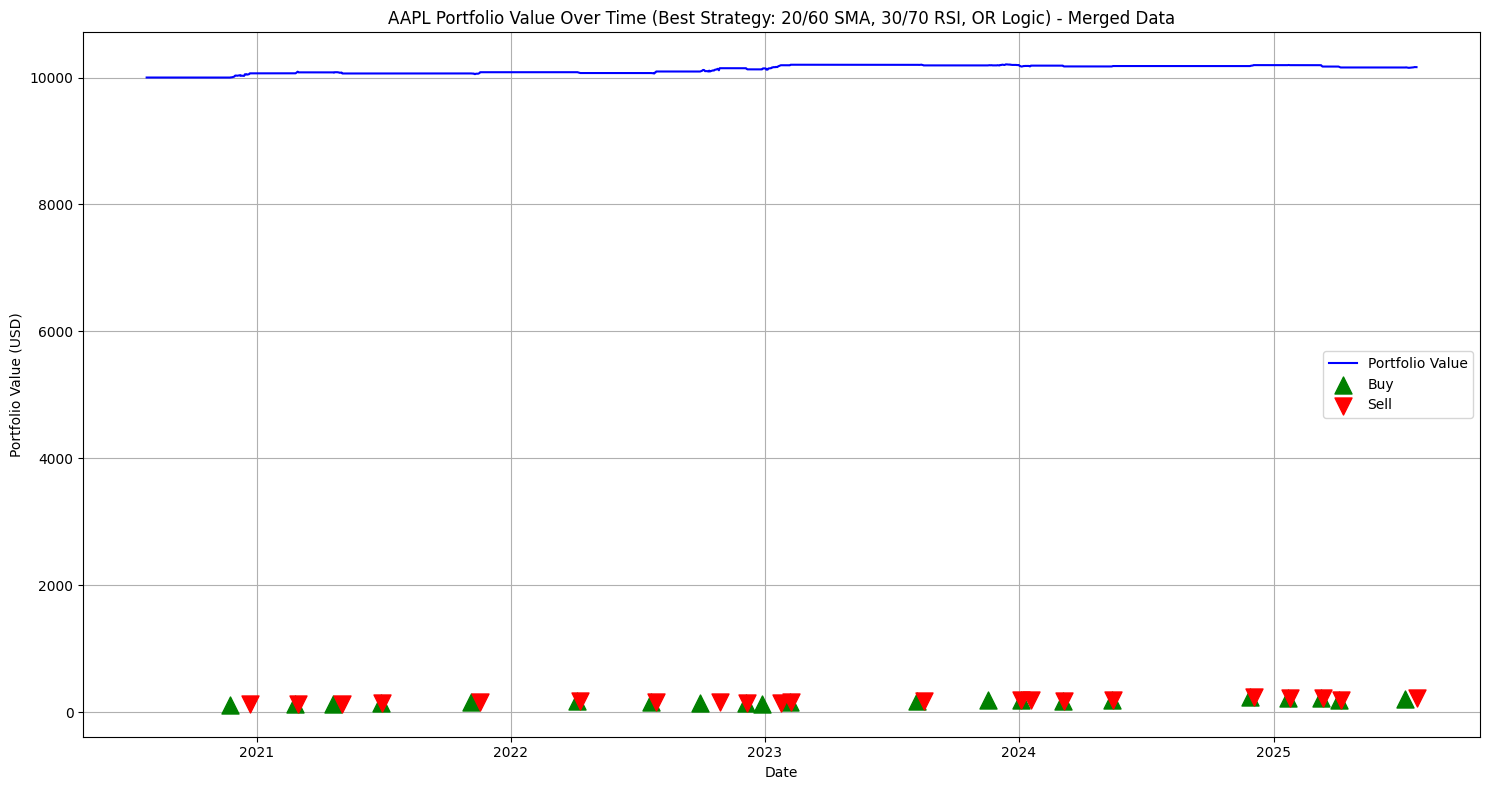

In [19]:
# Cell 19: Backtesting (Parameter Sweep and Best Strategy Identification)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Backtest Configuration ---
INITIAL_CAPITAL = 10000
STOP_LOSS_PERCENT = 0.05    # 5% stop loss
TAKE_PROFIT_PERCENT = 0.10  # 10% take profit
POSITION_SIZE_PERCENT = 0.10 # 10% of capital per trade (configurable)
FIXED_DOLLAR_POSITION_AMOUNT = None # Set to a specific dollar amount (e.g., 500) to use fixed dollar sizing, otherwise uses POSITION_SIZE_PERCENT
TRANSACTION_COST_PERCENT = 0.001 # 0.1% transaction cost per side (buy & sell)
# You can change these values here to experiment with different parameters.

# --- Helper Functions for Indicator Calculations ---
def calculate_sma(df, short_period, long_period):
    df = df.copy()
    df[f'SMA_{short_period}'] = df['close'].rolling(window=short_period).mean()
    df[f'SMA_{long_period}'] = df['close'].rolling(window=long_period).mean()
    return df

def calculate_rsi(df, window=14):
    df = df.copy()
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df[f'RSI_{window}'] = rsi
    return df

def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    df = df.copy()
    ema_fast = df['close'].ewm(span=fast_period, adjust=False).mean()
    ema_slow = df['close'].ewm(span=slow_period, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    df['MACD_Line'] = macd_line
    df['MACD_Signal'] = signal_line
    df['MACD_Histogram'] = macd_histogram
    return df

def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    df = df.copy()
    middle_band = df['close'].rolling(window=window).mean()
    std_dev = df['close'].rolling(window=window).std()
    upper_band = middle_band + (std_dev * num_std_dev)
    lower_band = middle_band - (std_dev * num_std_dev)
    df['BB_Middle'] = middle_band
    df['BB_Upper'] = upper_band
    df['BB_Lower'] = lower_band
    return df

def calculate_signals(df, sma_short, sma_long, rsi_oversold, rsi_overbought):
    df = df.copy()
    # SMA Crossover
    df['SMA_Crossover_Signal'] = 0
    if f'SMA_{sma_short}' in df.columns and f'SMA_{sma_long}' in df.columns:
        df['SMA_Diff'] = df[f'SMA_{sma_short}'] - df[f'SMA_{sma_long}']
        df['SMA_Crossover'] = (df['SMA_Diff'].shift(1) < 0) & (df['SMA_Diff'] > 0)
        df['SMA_Crossunder'] = (df['SMA_Diff'].shift(1) > 0) & (df['SMA_Diff'] < 0)
        df.loc[df['SMA_Crossover'], 'SMA_Crossover_Signal'] = 1
        df.loc[df['SMA_Crossunder'], 'SMA_Crossover_Signal'] = -1
        df.drop(columns=['SMA_Diff', 'SMA_Crossover', 'SMA_Crossunder'], inplace=True)
    # RSI Signal
    df['RSI_Signal'] = 0
    if 'RSI_14' in df.columns:
        df['RSI_Buy_Cross'] = (df['RSI_14'].shift(1) > rsi_oversold) & (df['RSI_14'] <= rsi_oversold)
        df['RSI_Sell_Cross'] = (df['RSI_14'].shift(1) < rsi_overbought) & (df['RSI_14'] >= rsi_overbought)
        df.loc[df['RSI_Buy_Cross'], 'RSI_Signal'] = 1
        df.loc[df['RSI_Sell_Cross'], 'RSI_Signal'] = -1
        df.drop(columns=['RSI_Buy_Cross', 'RSI_Sell_Cross'], inplace=True)
    # Combined Signals
    df['Combined_Signal'] = 0
    if 'SMA_Crossover_Signal' in df.columns and 'RSI_14' in df.columns:
        buy_condition = (df['SMA_Crossover_Signal'] == 1) & (df['RSI_14'] <= rsi_oversold)
        sell_condition = (df['SMA_Crossover_Signal'] == -1) & (df['RSI_14'] >= rsi_overbought)
        df.loc[buy_condition, 'Combined_Signal'] = 1
        df.loc[sell_condition, 'Combined_Signal'] = -1
    df['Combined_Signal_OR'] = 0
    df.loc[(df['SMA_Crossover_Signal'] == 1) | (df['RSI_Signal'] == 1), 'Combined_Signal_OR'] = 1
    df.loc[(df['SMA_Crossover_Signal'] == -1) | (df['RSI_Signal'] == -1), 'Combined_Signal_OR'] = -1
    return df

# --- Backtest Function ---
def run_backtest(df_signals, initial_capital, stop_loss_percent, take_profit_percent, position_size_percent, symbol_name, sma_short, sma_long, rsi_oversold, rsi_overbought, use_or_logic, transaction_cost_percent, fixed_dollar_amount=None):
    df = df_signals.copy()
    signal_col = 'Combined_Signal_OR' if use_or_logic else 'Combined_Signal'
    shares_held = 0
    capital = initial_capital
    trade_details = []
    current_buy_price = 0
    portfolio_value = [initial_capital]
    daily_returns_strategy = []
    for i in range(1, len(df)):
        current_close = df['close'].iloc[i]
        current_date = df.index[i]
        current_day_portfolio_value = capital + (shares_held * current_close) if shares_held > 0 else capital
        if len(portfolio_value) > 0 and portfolio_value[-1] != 0:
            daily_return_for_day = (current_day_portfolio_value / portfolio_value[-1]) - 1
            daily_returns_strategy.append(daily_return_for_day)
        else:
            daily_returns_strategy.append(0)
        # Stop-Loss/Take-Profit
        if shares_held > 0 and current_buy_price > 0:
            stop_loss_price = current_buy_price * (1 - stop_loss_percent)
            take_profit_price = current_buy_price * (1 + take_profit_percent)
            revenue = shares_held * current_close
            trade_cost = revenue * transaction_cost_percent
            if current_close <= stop_loss_price:
                trade_profit = ((current_close - current_buy_price) * shares_held) - trade_cost
                capital += (revenue - trade_cost)
                trade_details.append({'date': current_date, 'type': 'Sell (SL)', 'price': current_close, 'shares': shares_held, 'profit_loss': trade_profit})
                shares_held = 0
                current_buy_price = 0
            elif current_close >= take_profit_price:
                trade_profit = ((current_close - current_buy_price) * shares_held) - trade_cost
                capital += (revenue - trade_cost)
                trade_details.append({'date': current_date, 'type': 'Sell (TP)', 'price': current_close, 'shares': shares_held, 'profit_loss': trade_profit})
                shares_held = 0
                current_buy_price = 0
        # Signal logic
        signal = df[signal_col].iloc[i]
        if signal == 1 and shares_held == 0:
            if fixed_dollar_amount is not None:
                capital_to_allocate = fixed_dollar_amount
            else:
                capital_to_allocate = capital * position_size_percent
            shares_to_buy = int(capital_to_allocate / current_close)
            if shares_to_buy == 0 and capital >= current_close:
                shares_to_buy = 1
            if shares_to_buy > 0:
                cost = shares_to_buy * current_close
                trade_cost = cost * transaction_cost_percent
                capital -= (cost + trade_cost)
                shares_held = shares_to_buy
                current_buy_price = current_close
                trade_details.append({'date': current_date, 'type': 'Buy', 'price': current_close, 'shares': shares_held, 'profit_loss': -cost - trade_cost})
        elif signal == -1 and shares_held > 0:
            revenue = shares_held * current_close
            trade_cost = revenue * transaction_cost_percent
            trade_profit = ((current_close - current_buy_price) * shares_held) - trade_cost
            capital += (revenue - trade_cost)
            trade_details.append({'date': current_date, 'type': 'Sell (SIGNAL)', 'price': current_close, 'shares': shares_held, 'profit_loss': trade_profit})
            shares_held = 0
            current_buy_price = 0
        portfolio_value.append(capital + (shares_held * current_close))
    # Final close
    if shares_held > 0:
        final_close = df['close'].iloc[-1]
        revenue = shares_held * final_close
        trade_cost = revenue * transaction_cost_percent
        trade_profit = ((final_close - current_buy_price) * shares_held) - trade_cost
        capital += (revenue - trade_cost)
        trade_details.append({'date': df.index[-1], 'type': 'Sell (Final)', 'price': final_close, 'shares': shares_held, 'profit_loss': trade_profit})
        shares_held = 0
    final_portfolio_value = capital
    total_return_usd = final_portfolio_value - initial_capital
    total_return_percent = (total_return_usd / initial_capital) * 100
    winning_trades = [t for t in trade_details if t['type'].startswith('Sell') and t['profit_loss'] > 0]
    losing_trades = [t for t in trade_details if t['type'].startswith('Sell') and t['profit_loss'] < 0]
    total_trades_executed = len(winning_trades) + len(losing_trades)
    win_rate = (len(winning_trades) / total_trades_executed * 100) if total_trades_executed > 0 else 0
    avg_win = (sum(t['profit_loss'] for t in winning_trades) / len(winning_trades)) if winning_trades else 0
    avg_loss = (sum(t['profit_loss'] for t in losing_trades) / len(losing_trades)) if losing_trades else 0
    if len(daily_returns_strategy) > 0:
        daily_returns_series = pd.Series(daily_returns_strategy)
        cumulative_returns = (1 + daily_returns_series).cumprod()
        running_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = drawdown.min() * 100
        annualization_factor = np.sqrt(252)
        sharpe_ratio = (daily_returns_series.mean() / daily_returns_series.std()) * annualization_factor if daily_returns_series.std() != 0 else None
        downside_returns = daily_returns_series[daily_returns_series < 0]
        if not downside_returns.empty and downside_returns.std() != 0:
            downside_deviation = downside_returns.std()
            annualized_downside_deviation = downside_deviation * annualization_factor
            sortino_ratio = (daily_returns_series.mean() / annualized_downside_deviation) * annualization_factor
        else:
            sortino_ratio = None
    else:
        max_drawdown = None
        sharpe_ratio = None
        sortino_ratio = None
    results_summary = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': final_portfolio_value,
        'Total Trades Executed': total_trades_executed,
        'Winning Trades': len(winning_trades),
        'Losing Trades': len(losing_trades),
        'Win Rate (%)': win_rate,
        'Average Win (USD)': avg_win,
        'Average Loss (USD)': avg_loss,
        'Total Return (USD)': total_return_usd,
        'Total Return (%)': total_return_percent,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio (Annualized)': sharpe_ratio,
        'Sortino Ratio (Annualized)': sortino_ratio
    }
    return results_summary, trade_details, portfolio_value

# --- Parameter Grids ---
sma_short_periods = [10, 20, 30]
sma_long_periods = [30, 50, 60]
rsi_oversold_thresholds = [30, 40]
rsi_overbought_thresholds = [60, 70]
sl_percentages = [0.03, 0.05, 0.07]
tp_percentages = [0.08, 0.10, 0.12]
position_sizes = [0.05, 0.10, 0.15]
logic_types = [False, True]    # False=AND, True=OR

all_optimization_results = []

# Check if merged_df is available and has the required data for backtesting
if 'merged_df' in globals() and not merged_df.empty and 'close' in merged_df.columns:
    print(f"Starting parameter sweep optimization using merged data for {TARGET_SYMBOL}...")
    print(f"Data range: {merged_df.index.min()} to {merged_df.index.max()} ({len(merged_df)} days)")
    
    for s_short in sma_short_periods:
        for s_long in sma_long_periods:
            if s_short >= s_long:
                continue
            for rsi_os in rsi_oversold_thresholds:
                for rsi_ob in rsi_overbought_thresholds:
                    for sl_percent in sl_percentages:
                        for tp_percent in tp_percentages:
                            for pos_size in position_sizes:
                                for use_or_logic in logic_types:
                                    # Use merged_df instead of processed_twelvedata_historical_df
                                    df = merged_df.copy()
                                    df = calculate_sma(df, s_short, s_long)
                                    df = calculate_rsi(df, window=14)
                                    df = calculate_macd(df)
                                    df = calculate_bollinger_bands(df)
                                    df = calculate_signals(df, s_short, s_long, rsi_os, rsi_ob)
                                    current_results, _, _ = run_backtest(
                                        df_signals=df,
                                        initial_capital=INITIAL_CAPITAL,
                                        stop_loss_percent=sl_percent,
                                        take_profit_percent=tp_percent,
                                        position_size_percent=pos_size,
                                        symbol_name=TARGET_SYMBOL,
                                        sma_short=s_short,
                                        sma_long=s_long,
                                        rsi_oversold=rsi_os,
                                        rsi_overbought=rsi_ob,
                                        use_or_logic=use_or_logic,
                                        transaction_cost_percent=TRANSACTION_COST_PERCENT,
                                        fixed_dollar_amount=FIXED_DOLLAR_POSITION_AMOUNT
                                    )
                                    current_results['SMA Short'] = s_short
                                    current_results['SMA Long'] = s_long
                                    current_results['RSI Oversold'] = rsi_os
                                    current_results['RSI Overbought'] = rsi_ob
                                    current_results['SL %'] = sl_percent
                                    current_results['TP %'] = tp_percent
                                    current_results['Position Size %'] = pos_size
                                    current_results['Logic'] = 'OR' if use_or_logic else 'AND'
                                    all_optimization_results.append(current_results)

    # --- Present Results ---
    results_df = pd.DataFrame(all_optimization_results)
    results_df_sorted = results_df.sort_values(by=['Sharpe Ratio (Annualized)', 'Total Return (%)'], ascending=[False, False])

    # Display top 20 strategies
    print("\n=== Top 20 Strategies (Sorted by Sharpe Ratio, then Total Return) ===")
    print(results_df_sorted.head(20))

    # --- Identify and Visualize Best Strategy ---
    if not results_df_sorted.empty:
        best_strategy_params = results_df_sorted.iloc[0]
        print("\n--- Best Performing Strategy Parameters ---")
        print(best_strategy_params)

        # Extract best parameters
        best_s_short = int(best_strategy_params['SMA Short'])
        best_s_long = int(best_strategy_params['SMA Long'])
        best_rsi_os = int(best_strategy_params['RSI Oversold'])
        best_rsi_ob = int(best_strategy_params['RSI Overbought'])
        best_sl_percent = float(best_strategy_params['SL %'])
        best_tp_percent = float(best_strategy_params['TP %'])
        best_pos_size = float(best_strategy_params['Position Size %'])
        best_use_or_logic = True if best_strategy_params['Logic'] == 'OR' else False

        # Re-calculate indicators and signals for the best strategy using merged_df
        df_for_best_plot = merged_df.copy()
        df_for_best_plot = calculate_sma(df_for_best_plot, best_s_short, best_s_long)
        df_for_best_plot = calculate_rsi(df_for_best_plot, window=14)
        df_for_best_plot = calculate_macd(df_for_best_plot)
        df_for_best_plot = calculate_bollinger_bands(df_for_best_plot)
        df_for_best_plot = calculate_signals(df_for_best_plot, best_s_short, best_s_long, best_rsi_os, best_rsi_ob)

        # Re-run backtest for the best strategy
        best_summary, best_trade_details, best_portfolio_value = run_backtest(
            df_signals=df_for_best_plot,
            initial_capital=INITIAL_CAPITAL,
            stop_loss_percent=best_sl_percent,
            take_profit_percent=best_tp_percent,
            position_size_percent=best_pos_size,
            symbol_name=TARGET_SYMBOL,
            sma_short=best_s_short,
            sma_long=best_s_long,
            rsi_oversold=best_rsi_os,
            rsi_overbought=best_rsi_ob,
            use_or_logic=best_use_or_logic,
            transaction_cost_percent=TRANSACTION_COST_PERCENT,
            fixed_dollar_amount=FIXED_DOLLAR_POSITION_AMOUNT
        )

        # --- Plotting Best Strategy Portfolio Value with Trades ---
        plt.figure(figsize=(15, 8))
        # Ensure x and y are the same length for plotting
        plt.plot(df_for_best_plot.index, best_portfolio_value[:len(df_for_best_plot.index)], label='Portfolio Value', color='blue')

        buy_dates = [t['date'] for t in best_trade_details if t['type'] == 'Buy']
        buy_prices = [t['price'] for t in best_trade_details if t['type'] == 'Buy']
        sell_dates = [t['date'] for t in best_trade_details if t['type'].startswith('Sell')]
        sell_prices = [t['price'] for t in best_trade_details if t['type'].startswith('Sell')]

        plt.scatter(buy_dates, buy_prices, marker='^', color='green', s=150, label='Buy', zorder=5)
        plt.scatter(sell_dates, sell_prices, marker='v', color='red', s=150, label='Sell', zorder=5)

        plot_title_logic = 'OR' if best_use_or_logic else 'AND'
        plt.title(f'{TARGET_SYMBOL} Portfolio Value Over Time (Best Strategy: {best_s_short}/{best_s_long} SMA, {best_rsi_os}/{best_rsi_ob} RSI, {plot_title_logic} Logic) - Merged Data')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value (USD)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo strategies found to optimize.")
        
else:
    print(f"\nCannot run backtesting parameter sweep.")
    if 'merged_df' not in globals():
        print("- merged_df not available. Please run Cell 14 first to create merged data.")
    elif merged_df.empty:
        print("- merged_df is empty. Please check the data merging process in Cell 14.")
    elif 'close' not in merged_df.columns:
        print("- merged_df missing 'close' column. Please ensure Cell 14 adds the standardized close column.")

In [20]:
# Cell 20: Display Trade Metrics as a Formatted Table (from previous backtest)
import pandas as pd

# Use best_summary from the best strategy backtest if available
if 'results_summary' in globals():
    metrics_df = pd.DataFrame([results_summary]).T
    metrics_df.columns = ['Value']
    display(metrics_df)
elif 'best_summary' in globals():
    metrics_df = pd.DataFrame([best_summary]).T
    metrics_df.columns = ['Value']
    display(metrics_df)
else:
    print("Trade metrics unavailable: results_summary or best_summary not found. Please run the backtest cell first.")

,Value
Initial Capital,10000.000000
Final Portfolio Value,10163.078008
Total Trades Executed,21.000000
Winning Trades,12.000000
Losing Trades,9.000000
Win Rate (%),57.142857
Average Win (USD),24.440745
Average Loss (USD),-13.487821
Total Return (USD),163.078008
Total Return (%),1.630780


In [21]:
# Cell 21: Walk-Forward Optimization
import datetime
import pandas as pd # Ensure pandas is imported for Timestamp conversion

print("\n=== Starting Walk-Forward Optimization ===")

# --- Walk-Forward Configuration Parameters ---
# Define the length of the training (in-sample) period in days
# A common choice is 1-2 years (approx 252*1 or 252*2 trading days)
train_window_days = 252 * 1  # 1 year of trading days

# Define the length of the testing (out-of-sample) period in days
# A common choice is 3-6 months (approx 252/4 or 252/2 trading days)
test_window_days = 252 // 4  # 3 months of trading days

# Define how many days the window slides forward after each step
# Often, this is equal to the test_window_days for non-overlapping test periods
# Or smaller for more frequent re-optimization
step_days = test_window_days # Slide by 3 months each time

# Ensure merged_df is ready and has enough data
if 'merged_df' not in globals() or merged_df.empty or 'close' not in merged_df.columns:
    print("Error: merged_df is not available, empty, or missing 'close' column. Cannot perform Walk-Forward Optimization.")
    print("Please run Cell 14 first to create merged data, then Cells 9-12 to add indicators.")
    walk_forward_results = pd.DataFrame() # Initialize empty DataFrame to avoid errors
else:
    # Use merged_df which already has indicators and signals calculated
    # Ensure df_signals is sorted by date
    df_signals_wf = merged_df.sort_index().copy()

    # Drop rows with NaN in 'close' which might affect windowing
    df_signals_wf.dropna(subset=['close'], inplace=True)

    print(f"Using merged data for walk-forward optimization:")
    print(f"Data range: {df_signals_wf.index.min()} to {df_signals_wf.index.max()}")
    print(f"Total days available: {len(df_signals_wf)}")
    print(f"Training window: {train_window_days} days")
    print(f"Testing window: {test_window_days} days")

    # Re-calculate signals with default parameters for the full range,
    # as the run_backtest function will re-calculate for each sub-window based on its parameters.
    # This ensures df_signals_wf has the basic structure.
    df_signals_wf = calculate_sma(df_signals_wf, 10, 30) # Default SMA for initial structure
    df_signals_wf = calculate_rsi(df_signals_wf, window=14) # Default RSI for initial structure
    df_signals_wf = calculate_macd(df_signals_wf)
    df_signals_wf = calculate_bollinger_bands(df_signals_wf)
    df_signals_wf = calculate_signals(df_signals_wf, 10, 30, 40, 60) # Default signals for initial structure

    walk_forward_results = []
    
    # Convert dates to numerical index for easier slicing
    # This is important because trading days might not be continuous (weekends, holidays)
    dates = df_signals_wf.index.to_numpy()
    
    # Calculate initial start and end indices
    start_train_idx = 0
    end_train_idx = train_window_days - 1 # Adjusted to be 0-indexed length
    
    # Check if we have enough data for at least one walk-forward step
    if len(dates) < train_window_days + test_window_days:
        print(f"❌ Insufficient data for walk-forward optimization.")
        print(f"   Available: {len(dates)} days")
        print(f"   Required: {train_window_days + test_window_days} days (training + testing)")
        walk_forward_results_df = pd.DataFrame()
    else:
        # Loop through the data
        while end_train_idx < len(dates) - 1:
            # Define current training window
            train_start_date = dates[start_train_idx]
            train_end_date = dates[end_train_idx]
            
            # Define current testing window
            start_test_idx = end_train_idx + 1
            end_test_idx = min(start_test_idx + test_window_days - 1, len(dates) - 1)

            # If the test window is too small, break
            if end_test_idx <= start_test_idx:
                print(f"Skipping walk-forward step: Test window too small. Remaining data: {len(dates) - start_test_idx} days.")
                break

            test_start_date = dates[start_test_idx]
            test_end_date = dates[end_test_idx]

            # Convert numpy.datetime64 to pandas.Timestamp for strftime method
            print(f"\n--- Walk-Forward Step: Training {pd.Timestamp(train_start_date).strftime('%Y-%m-%d')} to {pd.Timestamp(train_end_date).strftime('%Y-%m-%d')} | Testing {pd.Timestamp(test_start_date).strftime('%Y-%m-%d')} to {pd.Timestamp(test_end_date).strftime('%Y-%m-%d')} ---")

            # Slice data for current training period
            train_df = df_signals_wf.loc[train_start_date:train_end_date].copy()
            
            if train_df.empty:
                print(f"Warning: Training data for {pd.Timestamp(train_start_date).strftime('%Y-%m-%d')} to {pd.Timestamp(train_end_date).strftime('%Y-%m-%d')} is empty. Skipping.")
                # Move to next window
                start_train_idx += step_days
                end_train_idx = start_train_idx + train_window_days - 1
                continue

            # --- Optimize on Training Data (Run Parameter Sweep) ---
            current_optimization_results = []
            for s_short in sma_short_periods:
                for s_long in sma_long_periods:
                    if s_short >= s_long:
                        continue
                    for rsi_os in rsi_oversold_thresholds:
                        for rsi_ob in rsi_overbought_thresholds:
                            for sl_percent in sl_percentages:
                                for tp_percent in tp_percentages:
                                    for pos_size in position_sizes:
                                        for use_or_logic in logic_types:
                                            # Recalculate indicators and signals for the current train_df
                                            temp_df = train_df.copy()
                                            temp_df = calculate_sma(temp_df, s_short, s_long)
                                            temp_df = calculate_rsi(temp_df, window=14)
                                            temp_df = calculate_macd(temp_df)
                                            temp_df = calculate_bollinger_bands(temp_df)
                                            temp_df = calculate_signals(temp_df, s_short, s_long, rsi_os, rsi_ob)

                                            # Run backtest on the training data
                                            summary, _, _ = run_backtest(
                                                df_signals=temp_df.dropna(), # Drop NaNs from indicator calculation
                                                initial_capital=INITIAL_CAPITAL,
                                                stop_loss_percent=sl_percent,
                                                take_profit_percent=tp_percent,
                                                position_size_percent=pos_size,
                                                symbol_name=TARGET_SYMBOL,
                                                sma_short=s_short,
                                                sma_long=s_long,
                                                rsi_oversold=rsi_os,
                                                rsi_overbought=rsi_ob,
                                                use_or_logic=use_or_logic,
                                                transaction_cost_percent=TRANSACTION_COST_PERCENT,
                                                fixed_dollar_amount=FIXED_DOLLAR_POSITION_AMOUNT
                                            )
                                            summary['SMA Short'] = s_short
                                            summary['SMA Long'] = s_long
                                            summary['RSI Oversold'] = rsi_os
                                            summary['RSI Overbought'] = rsi_ob
                                            summary['SL %'] = sl_percent
                                            summary['TP %'] = tp_percent
                                            summary['Position Size %'] = pos_size
                                            summary['Logic'] = 'OR' if use_or_logic else 'AND'
                                            current_optimization_results.append(summary)
            
            if not current_optimization_results:
                print("No optimization results for this training period. Skipping testing.")
                # Move to next window
                start_train_idx += step_days
                end_train_idx = start_train_idx + train_window_days - 1
                continue

            # Find best parameters from the current training period optimization
            optimization_df = pd.DataFrame(current_optimization_results)
            # Sort by Sharpe Ratio, then Total Return
            best_params_train = optimization_df.sort_values(by=['Sharpe Ratio (Annualized)', 'Total Return (%)'], ascending=[False, False]).iloc[0]

            # Handle potential None values for Sharpe Ratio and Sortino Ratio
            sharpe_ratio_display = f"{best_params_train['Sharpe Ratio (Annualized)']:.2f}" if best_params_train['Sharpe Ratio (Annualized)'] is not None else "N/A"
            
            print(f"Best parameters for this training period (Sharpe Ratio: {sharpe_ratio_display}):")
            print(best_params_train[['SMA Short', 'SMA Long', 'RSI Oversold', 'RSI Overbought', 'SL %', 'TP %', 'Position Size %', 'Logic']])

            # --- Test on Out-of-Sample Data ---
            test_df = df_signals_wf.loc[test_start_date:test_end_date].copy()
            
            if test_df.empty:
                print(f"Warning: Testing data for {pd.Timestamp(test_start_date).strftime('%Y-%m-%d')} to {pd.Timestamp(test_end_date).strftime('%Y-%m-%d')} is empty. Skipping.")
                # Move to next window
                start_train_idx += step_days
                end_train_idx = start_train_idx + train_window_days - 1
                continue

            # Apply best parameters from training to the testing data
            test_df_processed = test_df.copy()
            test_df_processed = calculate_sma(test_df_processed, int(best_params_train['SMA Short']), int(best_params_train['SMA Long']))
            test_df_processed = calculate_rsi(test_df_processed, window=14)
            test_df_processed = calculate_macd(test_df_processed)
            test_df_processed = calculate_bollinger_bands(test_df_processed)
            test_df_processed = calculate_signals(test_df_processed, int(best_params_train['SMA Short']), int(best_params_train['SMA Long']), int(best_params_train['RSI Oversold']), int(best_params_train['RSI Overbought']))

            test_summary, test_trade_details, test_portfolio_value = run_backtest(
                df_signals=test_df_processed.dropna(), # Drop NaNs from indicator calculation
                initial_capital=INITIAL_CAPITAL,
                stop_loss_percent=float(best_params_train['SL %']),
                take_profit_percent=float(best_params_train['TP %']),
                position_size_percent=float(best_params_train['Position Size %']),
                symbol_name=TARGET_SYMBOL,
                sma_short=int(best_params_train['SMA Short']),
                sma_long=int(best_params_train['SMA Long']),
                rsi_oversold=int(best_params_train['RSI Oversold']),
                rsi_overbought=int(best_params_train['RSI Overbought']),
                use_or_logic=best_params_train['Logic'] == 'OR',
                transaction_cost_percent=TRANSACTION_COST_PERCENT,
                fixed_dollar_amount=FIXED_DOLLAR_POSITION_AMOUNT
            )

            # Store results for this walk-forward step
            step_result = {
                'Train_Start_Date': pd.Timestamp(train_start_date).strftime('%Y-%m-%d'),
                'Train_End_Date': pd.Timestamp(train_end_date).strftime('%Y-%m-%d'),
                'Test_Start_Date': pd.Timestamp(test_start_date).strftime('%Y-%m-%d'),
                'Test_End_Date': pd.Timestamp(test_end_date).strftime('%Y-%m-%d'),
                'Optimized_SMA_Short': int(best_params_train['SMA Short']),
                'Optimized_SMA_Long': int(best_params_train['SMA Long']),
                'Optimized_RSI_Oversold': int(best_params_train['RSI Oversold']),
                'Optimized_RSI_Overbought': int(best_params_train['RSI Overbought']),
                'Optimized_SL_Percent': float(best_params_train['SL %']),
                'Optimized_TP_Percent': float(best_params_train['TP %']),
                'Optimized_Position_Size_Percent': float(best_params_train['Position Size %']),
                'Optimized_Logic': best_params_train['Logic'],
                'Test_Final_Portfolio_Value': test_summary['Final Portfolio Value'],
                'Test_Total_Return_Percent': test_summary['Total Return (%)'],
                'Test_Max_Drawdown_Percent': test_summary['Max Drawdown (%)'],
                'Test_Sharpe_Ratio': test_summary['Sharpe Ratio (Annualized)'],
                'Test_Sortino_Ratio': test_summary['Sortino Ratio (Annualized)'],
                'Test_Total_Trades': test_summary['Total Trades Executed'],
                'Test_Winning_Trades': test_summary['Winning Trades'],
                'Test_Losing_Trades': test_summary['Losing Trades'],
                'Test_Win_Rate_Percent': test_summary['Win Rate (%)']
            }
            walk_forward_results.append(step_result)

            # Move to the next window
            start_train_idx += step_days
            end_train_idx = start_train_idx + train_window_days - 1

        walk_forward_results_df = pd.DataFrame(walk_forward_results)
        print("\n=== Walk-Forward Optimization Complete ===")
        
        if not walk_forward_results_df.empty:
            print("\nWalk-Forward Results (per testing period):")
            print(walk_forward_results_df)

            print("\nOverall Walk-Forward Performance Summary (Mean of Testing Periods):")
            print(walk_forward_results_df.mean(numeric_only=True))

            print("\nOverall Walk-Forward Performance Summary (Aggregated Metrics):")
            # Aggregate total trades, wins, losses
            total_wf_trades = walk_forward_results_df['Test_Total_Trades'].sum()
            total_wf_wins = walk_forward_results_df['Test_Winning_Trades'].sum()
            total_wf_losses = walk_forward_results_df['Test_Losing_Trades'].sum()
            overall_wf_win_rate = (total_wf_wins / total_wf_trades * 100) if total_wf_trades > 0 else 0

            # Calculate overall return by compounding returns from each test period
            overall_cumulative_return_factor = (1 + walk_forward_results_df['Test_Total_Return_Percent'] / 100).prod()
            overall_total_return_percent = (overall_cumulative_return_factor - 1) * 100

            print(f"Total Walk-Forward Trades: {total_wf_trades}")
            print(f"Overall Walk-Forward Win Rate (%): {overall_wf_win_rate:.2f}")
            print(f"Overall Walk-Forward Total Return (%): {overall_total_return_percent:.2f}")
            
            # Handle potential None values in mean calculations for Sharpe/Sortino
            avg_sharpe = walk_forward_results_df['Test_Sharpe_Ratio'].mean()
            avg_sharpe_display = f"{avg_sharpe:.2f}" if pd.notna(avg_sharpe) else "N/A"
            print(f"Average Test Sharpe Ratio: {avg_sharpe_display}")

            avg_max_drawdown = walk_forward_results_df['Test_Max_Drawdown_Percent'].mean()
            avg_max_drawdown_display = f"{avg_max_drawdown:.2f}" if pd.notna(avg_max_drawdown) else "N/A"
            print(f"Average Test Max Drawdown (%): {avg_max_drawdown_display}")
        else:
            print("❌ No walk-forward results generated. Data may be insufficient for the configured window sizes.")


=== Starting Walk-Forward Optimization ===
Using merged data for walk-forward optimization:
Data range: 2020-07-27 00:00:00 to 2025-07-25 00:00:00
Total days available: 1305
Training window: 252 days
Testing window: 63 days

--- Walk-Forward Step: Training 2020-07-27 to 2021-07-13 | Testing 2021-07-14 to 2021-10-08 ---
Best parameters for this training period (Sharpe Ratio: 2.47):
SMA Short            20
SMA Long             60
RSI Oversold         30
RSI Overbought       60
SL %               0.03
TP %               0.08
Position Size %    0.15
Logic                OR
Name: 1085, dtype: object

--- Walk-Forward Step: Training 2020-10-22 to 2021-10-08 | Testing 2021-10-11 to 2022-01-05 ---
Best parameters for this training period (Sharpe Ratio: 2.47):
SMA Short            20
SMA Long             60
RSI Oversold         30
RSI Overbought       60
SL %               0.03
TP %               0.08
Position Size %    0.15
Logic                OR
Name: 1085, dtype: object

--- Walk-Forward S

Best parameters for this training period (Sharpe Ratio: 2.80):
SMA Short            30
SMA Long             50
RSI Oversold         30
RSI Overbought       70
SL %               0.03
TP %               0.08
Position Size %    0.15
Logic                OR
Name: 1355, dtype: object

--- Walk-Forward Step: Training 2021-07-14 to 2022-06-30 | Testing 2022-07-01 to 2022-09-27 ---
Best parameters for this training period (Sharpe Ratio: 1.02):
SMA Short            10
SMA Long             50
RSI Oversold         30
RSI Overbought       60
SL %               0.03
TP %               0.08
Position Size %    0.05
Logic                OR
Name: 217, dtype: object

--- Walk-Forward Step: Training 2021-10-11 to 2022-09-27 | Testing 2022-09-28 to 2022-12-23 ---
Best parameters for this training period (Sharpe Ratio: 1.02):
SMA Short            10
SMA Long             50
RSI Oversold         30
RSI Overbought       60
SL %               0.03
TP %               0.08
Position Size %    0.05
Logic         


=== Plotting Walk-Forward Cumulative Returns ===

Overall Walk-Forward Final Portfolio Value: $9958.48
Overall Walk-Forward Total Return: -0.42%

Overall Walk-Forward Final Portfolio Value: $9958.48
Overall Walk-Forward Total Return: -0.42%


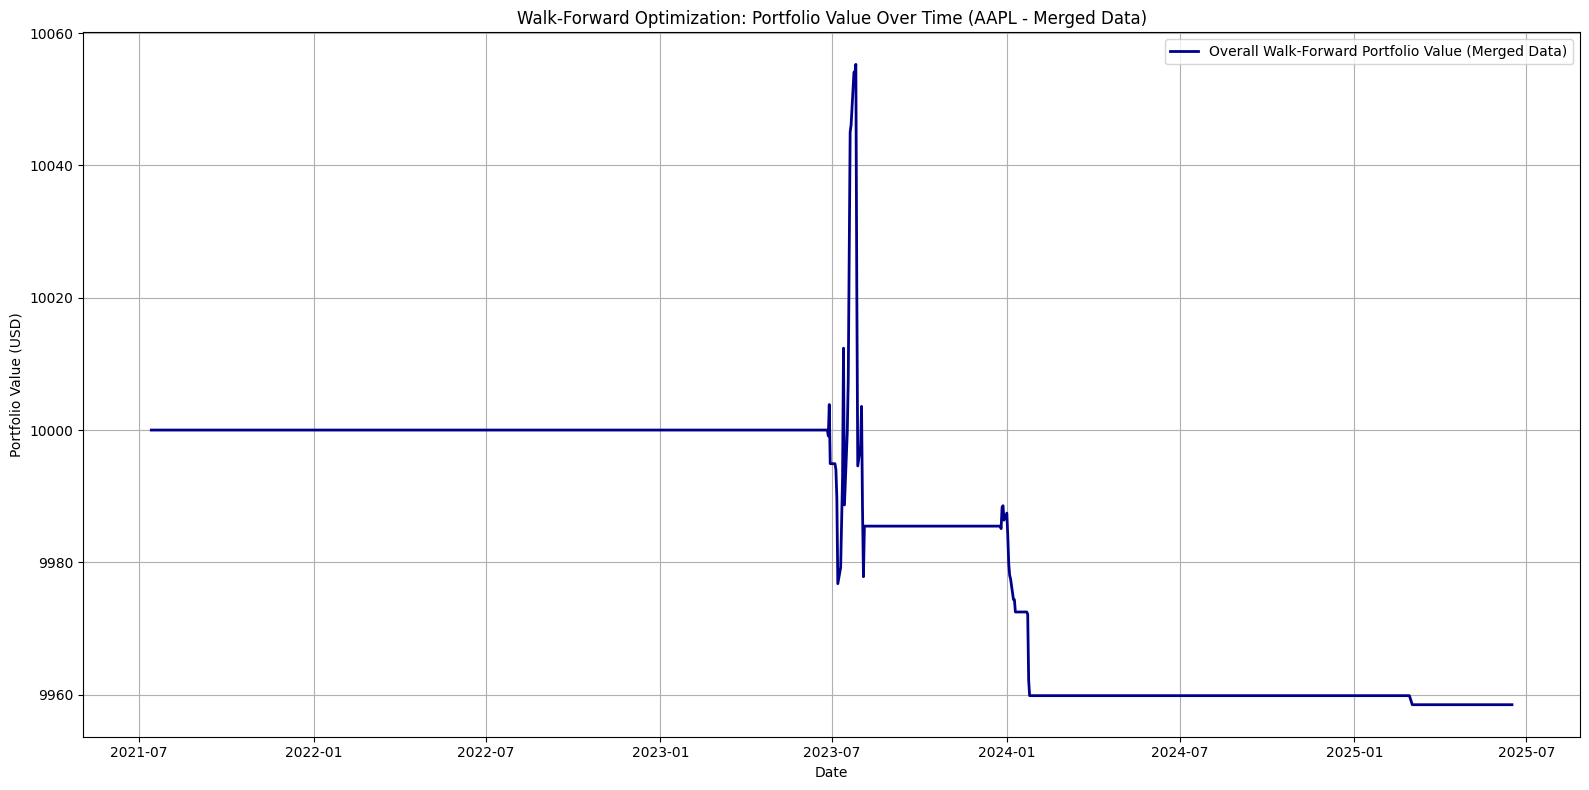


=== Walk-Forward Plotting Complete ===


In [22]:
# Cell 22: Plot Walk-Forward Cumulative Returns
import matplotlib.pyplot as plt
import pandas as pd

print("\n=== Plotting Walk-Forward Cumulative Returns ===")

if 'walk_forward_results_df' in globals() and not walk_forward_results_df.empty:
    plt.figure(figsize=(16, 8))

    # To plot overall compounded return, we need to re-run backtests on the test periods
    # using the optimized parameters from the training periods, and then chain the portfolio values.
    
    overall_portfolio_values = pd.Series([INITIAL_CAPITAL], index=[merged_df.index.min()]) # Start with initial capital at the earliest data point
    
    # Ensure merged_df is available and properly indexed
    if 'merged_df' not in globals() or merged_df.empty or 'close' not in merged_df.columns:
        print("Error: merged_df is not available, empty, or missing 'close' column. Cannot plot walk-forward cumulative returns.")
        print("Please run Cell 14 first to create merged data.")
    else:
        df_full_signals = merged_df.sort_index().copy()
        df_full_signals.dropna(subset=['close'], inplace=True)

        # Re-calculate indicators for the full range once to ensure they are present for slicing
        df_full_signals = calculate_sma(df_full_signals, 10, 30)
        df_full_signals = calculate_rsi(df_full_signals, window=14)
        df_full_signals = calculate_macd(df_full_signals)
        df_full_signals = calculate_bollinger_bands(df_full_signals)
        df_full_signals = calculate_signals(df_full_signals, 10, 30, 40, 60) # Default signals for initial structure

        current_capital_for_chaining = INITIAL_CAPITAL
        chained_returns_index = []
        chained_returns_values = []

        for index, row in walk_forward_results_df.iterrows():
            test_start_date = pd.to_datetime(row['Test_Start_Date'])
            test_end_date = pd.to_datetime(row['Test_End_Date'])

            # Slice data for current testing period
            test_df_segment = df_full_signals.loc[test_start_date:test_end_date].copy()
            
            if test_df_segment.empty:
                print(f"  Warning: Test segment for {test_start_date.strftime('%Y-%m-%d')} to {test_end_date.strftime('%Y-%m-%d')} is empty. Skipping.")
                continue

            # Apply optimized parameters from the training phase to this test segment
            test_df_processed_segment = test_df_segment.copy()
            test_df_processed_segment = calculate_sma(test_df_processed_segment, int(row['Optimized_SMA_Short']), int(row['Optimized_SMA_Long']))
            test_df_processed_segment = calculate_rsi(test_df_processed_segment, window=14)
            test_df_processed_segment = calculate_macd(test_df_processed_segment)
            test_df_processed_segment = calculate_bollinger_bands(test_df_processed_segment)
            test_df_processed_segment = calculate_signals(test_df_processed_segment, int(row['Optimized_SMA_Short']), int(row['Optimized_SMA_Long']), int(row['Optimized_RSI_Oversold']), int(row['Optimized_RSI_Overbought']))

            # Run backtest on the test segment using the *chained* capital from the previous period
            # We pass the current_capital_for_chaining and get the portfolio_value for this segment
            _, _, segment_portfolio_value = run_backtest(
                df_signals=test_df_processed_segment.dropna(),
                initial_capital=current_capital_for_chaining, # Use chained capital
                stop_loss_percent=float(row['Optimized_SL_Percent']),
                take_profit_percent=float(row['Optimized_TP_Percent']),
                position_size_percent=float(row['Optimized_Position_Size_Percent']),
                symbol_name=TARGET_SYMBOL,
                sma_short=int(row['Optimized_SMA_Short']),
                sma_long=int(row['Optimized_SMA_Long']),
                rsi_oversold=int(row['Optimized_RSI_Oversold']),
                rsi_overbought=int(row['Optimized_RSI_Overbought']),
                use_or_logic=row['Optimized_Logic'] == 'OR',
                transaction_cost_percent=TRANSACTION_COST_PERCENT,
                fixed_dollar_amount=FIXED_DOLLAR_POSITION_AMOUNT
            )
            
            # If the segment_portfolio_value has more than one entry (i.e., actual trading days),
            # append its values, normalized to the start of the segment, and then scaled by current_capital_for_chaining.
            if len(segment_portfolio_value) > 1:
                segment_series = pd.Series(segment_portfolio_value, index=test_df_processed_segment.index[:len(segment_portfolio_value)])
                
                # Normalize the segment's portfolio value to its start, then scale by the capital at the start of this segment
                normalized_segment_series = (segment_series / segment_series.iloc[0]) * current_capital_for_chaining
                
                # Append to chained results, avoiding duplicate index entries if any
                for date, value in normalized_segment_series.items():
                    if date not in chained_returns_index:
                        chained_returns_index.append(date)
                        chained_returns_values.append(value)
                
                # Update current_capital_for_chaining for the next iteration
                current_capital_for_chaining = normalized_segment_series.iloc[-1]
            else:
                # If no trades or only one data point in the segment, portfolio value remains unchanged
                # We still need to extend the index and value for continuity in the plot
                if not test_df_processed_segment.empty:
                    last_date_of_segment = test_df_processed_segment.index[-1]
                    if last_date_of_segment not in chained_returns_index:
                        chained_returns_index.append(last_date_of_segment)
                        chained_returns_values.append(current_capital_for_chaining) # Capital remains the same
                
        if chained_returns_values:
            overall_portfolio_values = pd.Series(chained_returns_values, index=chained_returns_index).sort_index()
            plt.plot(overall_portfolio_values.index, overall_portfolio_values, label='Overall Walk-Forward Portfolio Value (Merged Data)', color='darkblue', linewidth=2)
            print(f"\nOverall Walk-Forward Final Portfolio Value: ${overall_portfolio_values.iloc[-1]:.2f}")
            print(f"Overall Walk-Forward Total Return: {((overall_portfolio_values.iloc[-1] / INITIAL_CAPITAL) - 1) * 100:.2f}%")
        else:
            print("No valid walk-forward test segments to plot overall portfolio value.")

    plt.title(f'Walk-Forward Optimization: Portfolio Value Over Time ({TARGET_SYMBOL} - Merged Data)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("Walk-forward results DataFrame not found or is empty. Please run Cell 21 first.")

print("\n=== Walk-Forward Plotting Complete ===")